In [8]:
import os
import json
import pandas as pd
import numpy as np
from scipy.stats import variation, moment, norm
from scipy.signal import find_peaks, butter, filtfilt, detrend, medfilt
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
import time
import pywt

# Directory paths
base_dir = r"D:\eSports_Sensors_Dataset-master"
match_dir = os.path.join(base_dir, "matches")


In [17]:
# Cell 2: GSR Preprocessing with only wavelet denoising
def wavelet_denoise_gsr_signal(gsr_data, wavelet='haar', artifact_proportion=0.01):
    """
    Perform wavelet-based motion artifact removal on GSR data using stationary wavelet transform (SWT).
    
    Parameters:
    - gsr_data: array-like
        The raw GSR signal data.
    - wavelet: str, default 'haar'
        The type of wavelet to use (e.g., 'haar').
    - artifact_proportion: float, default 0.01
        The proportion of motion artifacts in the signal.

    Returns:
    - denoised_signal: array-like
        The denoised GSR signal after wavelet thresholding.
    """
    # Ensure that the length of the data is even
    if len(gsr_data) % 2 != 0:
        gsr_data = gsr_data[:-1]  # Trim the last element if the length is odd

    # Calculate maximum level for wavelet decomposition based on the length of the data
    max_level = pywt.swt_max_level(len(gsr_data))

    # Perform stationary wavelet transform (SWT)
    coeffs = pywt.swt(gsr_data, wavelet, level=max_level)

    # Separate the detail coefficients and apply thresholding
    denoised_coeffs = []
    for detail in [c[1] for c in coeffs]:  # Extract detail coefficients (cD)
        # Fit Gaussian to coefficients and compute threshold
        mu, std = norm.fit(detail)
        threshold = std * np.sqrt(2 * np.log(len(detail)))

        # Apply soft thresholding to remove motion artifacts
        detail_thresholded = pywt.threshold(detail, threshold, mode='soft')

        # Append approximation coefficients as zero and thresholded details
        denoised_coeffs.append((np.zeros_like(detail), detail_thresholded))

    # Reconstruct the signal using inverse stationary wavelet transform (ISWT)
    denoised_signal = pywt.iswt(denoised_coeffs, wavelet)

    return denoised_signal

# GSR Signal Preprocessing
def preprocess_gsr_signal(gsr_data):
    """
    Preprocess GSR signal by applying only wavelet denoising.
    
    Parameters:
    - gsr_data: array-like
        The raw GSR signal.

    Returns:
    - Preprocessed GSR signal after wavelet denoising.
    """
    return wavelet_denoise_gsr_signal(gsr_data)


In [18]:
def extract_signal_features(signal):
    """
    Extract statistical features from a signal.
    """
    mean_value = np.mean(signal)
    std_deviation = np.std(signal)
    signal_range = np.max(signal) - np.min(signal)
    skewness = moment(signal, moment=3) / np.std(signal) ** 3
    kurtosis = moment(signal, moment=4) / np.std(signal) ** 4 - 3
    peaks, _ = find_peaks(signal)
    peak_count = len(peaks)
    return mean_value, std_deviation, signal_range, skewness, kurtosis, peak_count

def extract_gsr_features(gsr_data):
    """
    Extract features from GSR data using both CVXEDA and SparsEDA.
    """
    # Preprocess the GSR signal (only wavelet denoising is used)
    y = preprocess_gsr_signal(gsr_data)

    # CVXEDA processing
    start_time = time.time()
    phasic_cvxeda, _, tonic_cvxeda, _, _, _, _ = cvxEDA(y, delta=0.05)
    cvxeda_time = time.time() - start_time
    phasic_features_cvxeda = extract_signal_features(phasic_cvxeda)
    tonic_features_cvxeda = extract_signal_features(tonic_cvxeda)

    # SparsEDA processing
    sr = 2  # Sampling rate
    epsilon = 0.005
    Kmax = 1500
    dmin = 1
    rho = 0.05
    start_time = time.time()
    driver, SCL, _ = sparsEDA(y, sr, epsilon, Kmax, dmin, rho)
    sparseda_time = time.time() - start_time
    phasic_features_sparseda = extract_signal_features(driver)
    tonic_features_sparseda = extract_signal_features(SCL)

    # Calculate MSE between CVXEDA and SparsEDA components
    mse_phasic = mean_squared_error(phasic_cvxeda, driver)
    mse_tonic = mean_squared_error(tonic_cvxeda, SCL)

    return (phasic_features_cvxeda, tonic_features_cvxeda, phasic_features_sparseda, tonic_features_sparseda,
            cvxeda_time, sparseda_time, mse_phasic, mse_tonic)


In [19]:
def process_player_data(player_path, match_folder, player_folder):
    """
    Process each player's data to extract heart rate and GSR features.
    """
    heart_rate_file = os.path.join(player_path, "heart_rate.csv")
    gsr_file = os.path.join(player_path, "gsr.csv")
    mental_load_file = os.path.join(player_path, "player_report.json")

    if os.path.exists(heart_rate_file) and os.path.exists(gsr_file) and os.path.exists(mental_load_file):
        df_heart_rate = pd.read_csv(heart_rate_file)
        heart_rate_data = df_heart_rate['heart_rate'].values

        df_gsr = pd.read_csv(gsr_file)
        gsr_data = df_gsr['gsr'].values

        with open(mental_load_file, 'r') as f:
            player_report = json.load(f)
            mental_load = player_report.get('mental_load', 'Unknown')

        hr_features = extract_hr_features(heart_rate_data)
        (phasic_features_cvxeda, tonic_features_cvxeda, phasic_features_sparseda, tonic_features_sparseda,
         cvxeda_time, sparseda_time, mse_phasic, mse_tonic) = extract_gsr_features(gsr_data)

        combined_features = hr_features + phasic_features_cvxeda + tonic_features_cvxeda + phasic_features_sparseda + tonic_features_sparseda + (cvxeda_time, sparseda_time, mse_phasic, mse_tonic, mental_load)
        return combined_features, gsr_data
    return None, None


In [21]:
import matplotlib.pyplot as plt

# Function to plot GSR signals (raw, denoised, and decomposed)
def plot_gsr_comparison(raw_gsr_data, denoised_gsr_data, phasic_cvxeda, tonic_cvxeda, driver_sparseda, SCL_sparseda, sample_idx=0):
    """
    Plot raw GSR signal, wavelet-denoised GSR signal, and decomposed signals (CVXEDA and SparsEDA).
    
    Parameters:
    - raw_gsr_data: array-like
        The raw GSR signal data.
    - denoised_gsr_data: array-like
        The GSR signal after wavelet denoising.
    - phasic_cvxeda: array-like
        Phasic component from CVXEDA.
    - tonic_cvxeda: array-like
        Tonic component from CVXEDA.
    - driver_sparseda: array-like
        Phasic component from SparsEDA.
    - SCL_sparseda: array-like
        Tonic component from SparsEDA.
    - sample_idx: int
        The index of the sample (default: 0)
    """
    
    plt.figure(figsize=(15, 12))

    # Plot raw GSR signal
    plt.subplot(4, 1, 1)
    plt.plot(raw_gsr_data, label='Raw GSR Signal', color='black')
    plt.title(f'Raw GSR Signal for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot wavelet-denoised GSR signal
    plt.subplot(4, 1, 2)
    plt.plot(denoised_gsr_data, label='Wavelet-Denoised GSR Signal', color='blue')
    plt.title(f'Wavelet-Denoised GSR Signal for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot decomposed GSR signal - CVXEDA (Phasic and Tonic)
    plt.subplot(4, 1, 3)
    plt.plot(phasic_cvxeda, label='CVXEDA Phasic Component', color='red')
    plt.plot(tonic_cvxeda, label='CVXEDA Tonic Component', color='green')
    plt.title(f'CVXEDA Decomposition for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot decomposed GSR signal - SparsEDA (Phasic and Tonic)
    plt.subplot(4, 1, 4)
    plt.plot(driver_sparseda, label='SparsEDA Phasic Component', color='magenta')
    plt.plot(SCL_sparseda, label='SparsEDA Tonic Component', color='cyan')
    plt.title(f'SparsEDA Decomposition for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Updated process_player_data function to include plotting
def process_player_data_and_plot(player_path, match_folder, player_folder):
    """
    Process each player's data, extract heart rate and GSR features, and plot GSR signals.
    """
    heart_rate_file = os.path.join(player_path, "heart_rate.csv")
    gsr_file = os.path.join(player_path, "gsr.csv")
    mental_load_file = os.path.join(player_path, "player_report.json")

    if os.path.exists(heart_rate_file) and os.path.exists(gsr_file) and os.path.exists(mental_load_file):
        df_heart_rate = pd.read_csv(heart_rate_file)
        heart_rate_data = df_heart_rate['heart_rate'].values

        df_gsr = pd.read_csv(gsr_file)
        gsr_data = df_gsr['gsr'].values

        with open(mental_load_file, 'r') as f:
            player_report = json.load(f)
            mental_load = player_report.get('mental_load', 'Unknown')

        # Preprocess GSR with wavelet denoising
        denoised_gsr_data = preprocess_gsr_signal(gsr_data)

        # Decompose the denoised signal using CVXEDA and SparsEDA
        phasic_cvxeda, _, tonic_cvxeda, _, _, _, _ = cvxEDA(denoised_gsr_data, delta=0.05)
        sr = 2  # Sampling rate
        epsilon = 0.005
        Kmax = 1500
        dmin = 1
        rho = 0.05
        driver_sparseda, SCL_sparseda, _ = sparsEDA(denoised_gsr_data, sr, epsilon, Kmax, dmin, rho)

        # Plot GSR signals (raw, denoised, and decomposed)
        plot_gsr_comparison(gsr_data, denoised_gsr_data, phasic_cvxeda, tonic_cvxeda, driver_sparseda, SCL_sparseda)

        # Extract HR and GSR features
        hr_features = extract_hr_features(heart_rate_data)
        (phasic_features_cvxeda, tonic_features_cvxeda, phasic_features_sparseda, tonic_features_sparseda,
         cvxeda_time, sparseda_time, mse_phasic, mse_tonic) = extract_gsr_features(gsr_data)

        combined_features = hr_features + phasic_features_cvxeda + tonic_features_cvxeda + phasic_features_sparseda + tonic_features_sparseda + (cvxeda_time, sparseda_time, mse_phasic, mse_tonic, mental_load)
        return combined_features, gsr_data
    return None, None


In [22]:
if __name__ == "__main__":
    player_path = 'path_to_player_data'
    match_folder = 'match_folder_name'
    player_folder = 'player_folder_name'
    process_player_data_and_plot(player_path, match_folder, player_folder)


Randomly selected player path: D:\eSports_Sensors_Dataset-master\matches\match_13\player_1
Random match folder: match_13
Random player folder: player_1
     pcost       dcost       gap    pres   dres
 0: -4.2231e+03 -4.2144e+03  3e+03  5e+01  2e-01
 1: -4.2260e+03 -4.5404e+03  4e+02  6e+00  2e-02
 2: -4.2337e+03 -4.3471e+03  1e+02  2e+00  5e-03
 3: -4.2389e+03 -4.2882e+03  5e+01  5e-01  1e-03
 4: -4.2419e+03 -4.2686e+03  3e+01  2e-01  6e-04
 5: -4.2434e+03 -4.2557e+03  1e+01  7e-02  2e-04
 6: -4.2446e+03 -4.2480e+03  3e+00  1e-02  3e-05
 7: -4.2456e+03 -4.2467e+03  1e+00  3e-03  8e-06
 8: -4.2460e+03 -4.2463e+03  2e-01  3e-04  9e-07
 9: -4.2461e+03 -4.2462e+03  6e-02  5e-05  1e-07
10: -4.2462e+03 -4.2462e+03  1e-02  1e-05  3e-08
11: -4.2462e+03 -4.2462e+03  3e-03  1e-06  4e-09
12: -4.2462e+03 -4.2462e+03  5e-04  2e-07  6e-10
13: -4.2462e+03 -4.2462e+03  6e-05  1e-08  4e-11
14: -4.2462e+03 -4.2462e+03  3e-06  7e-10  2e-12
Optimal solution found.


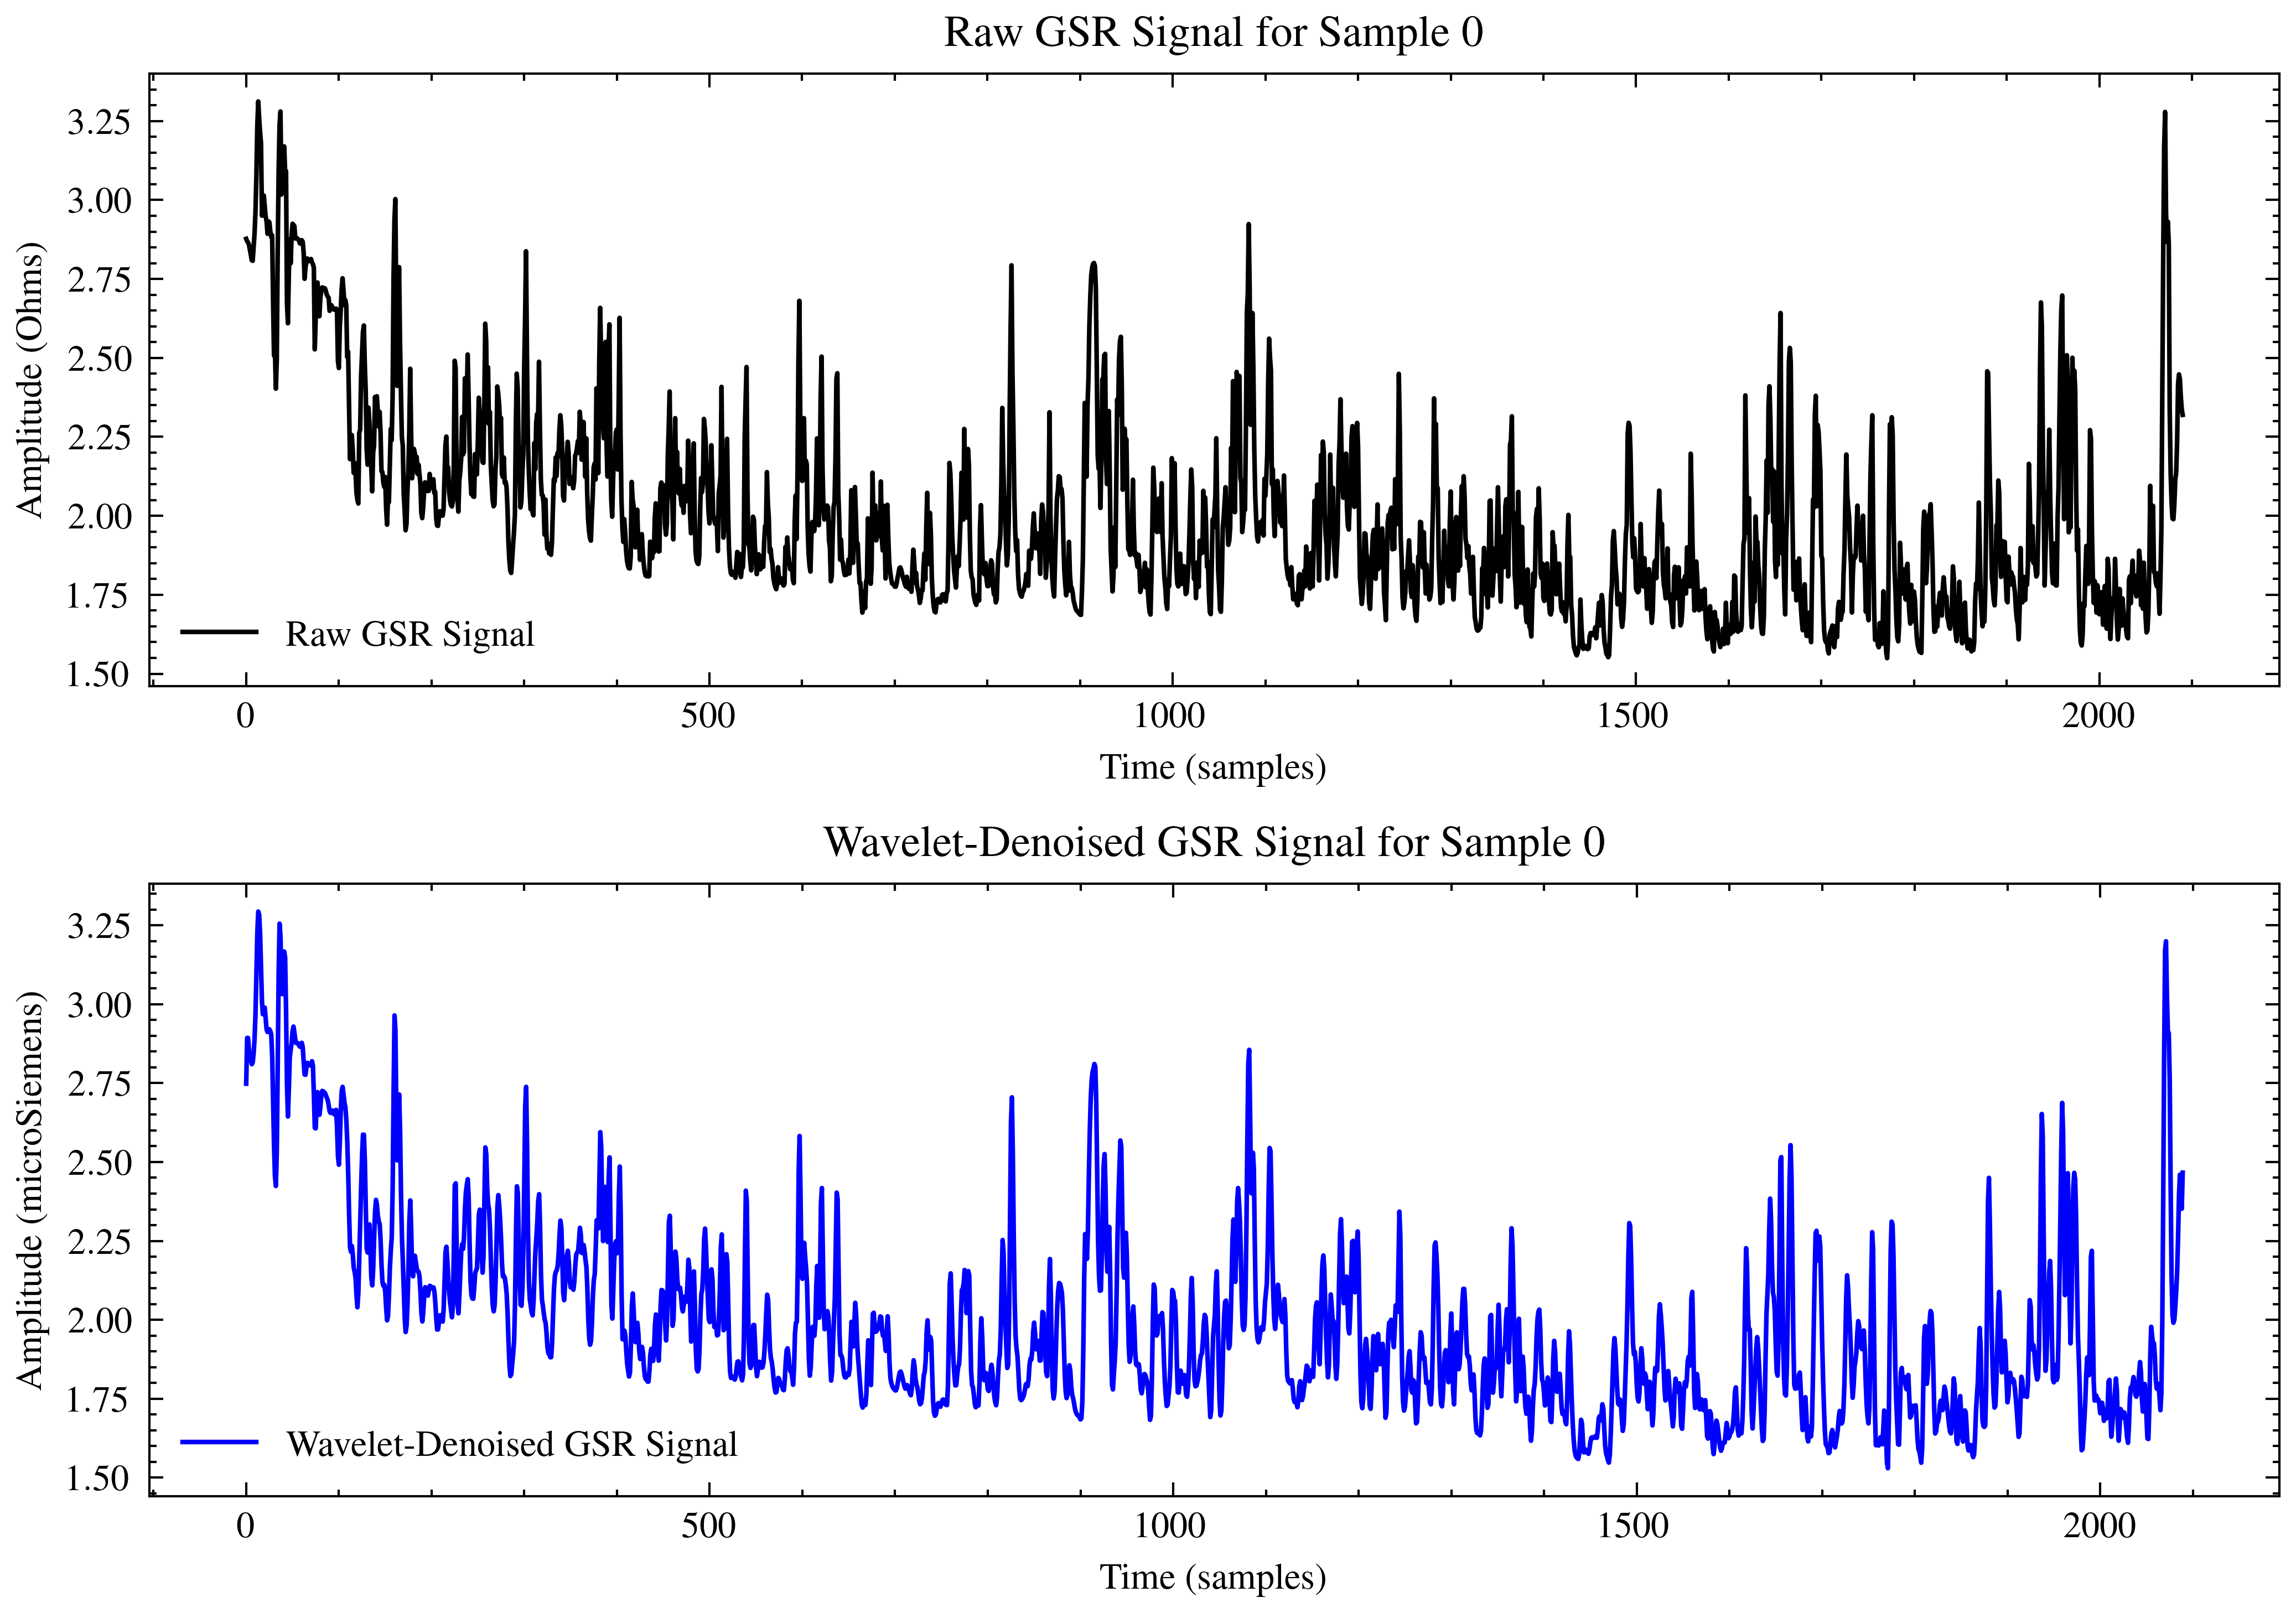

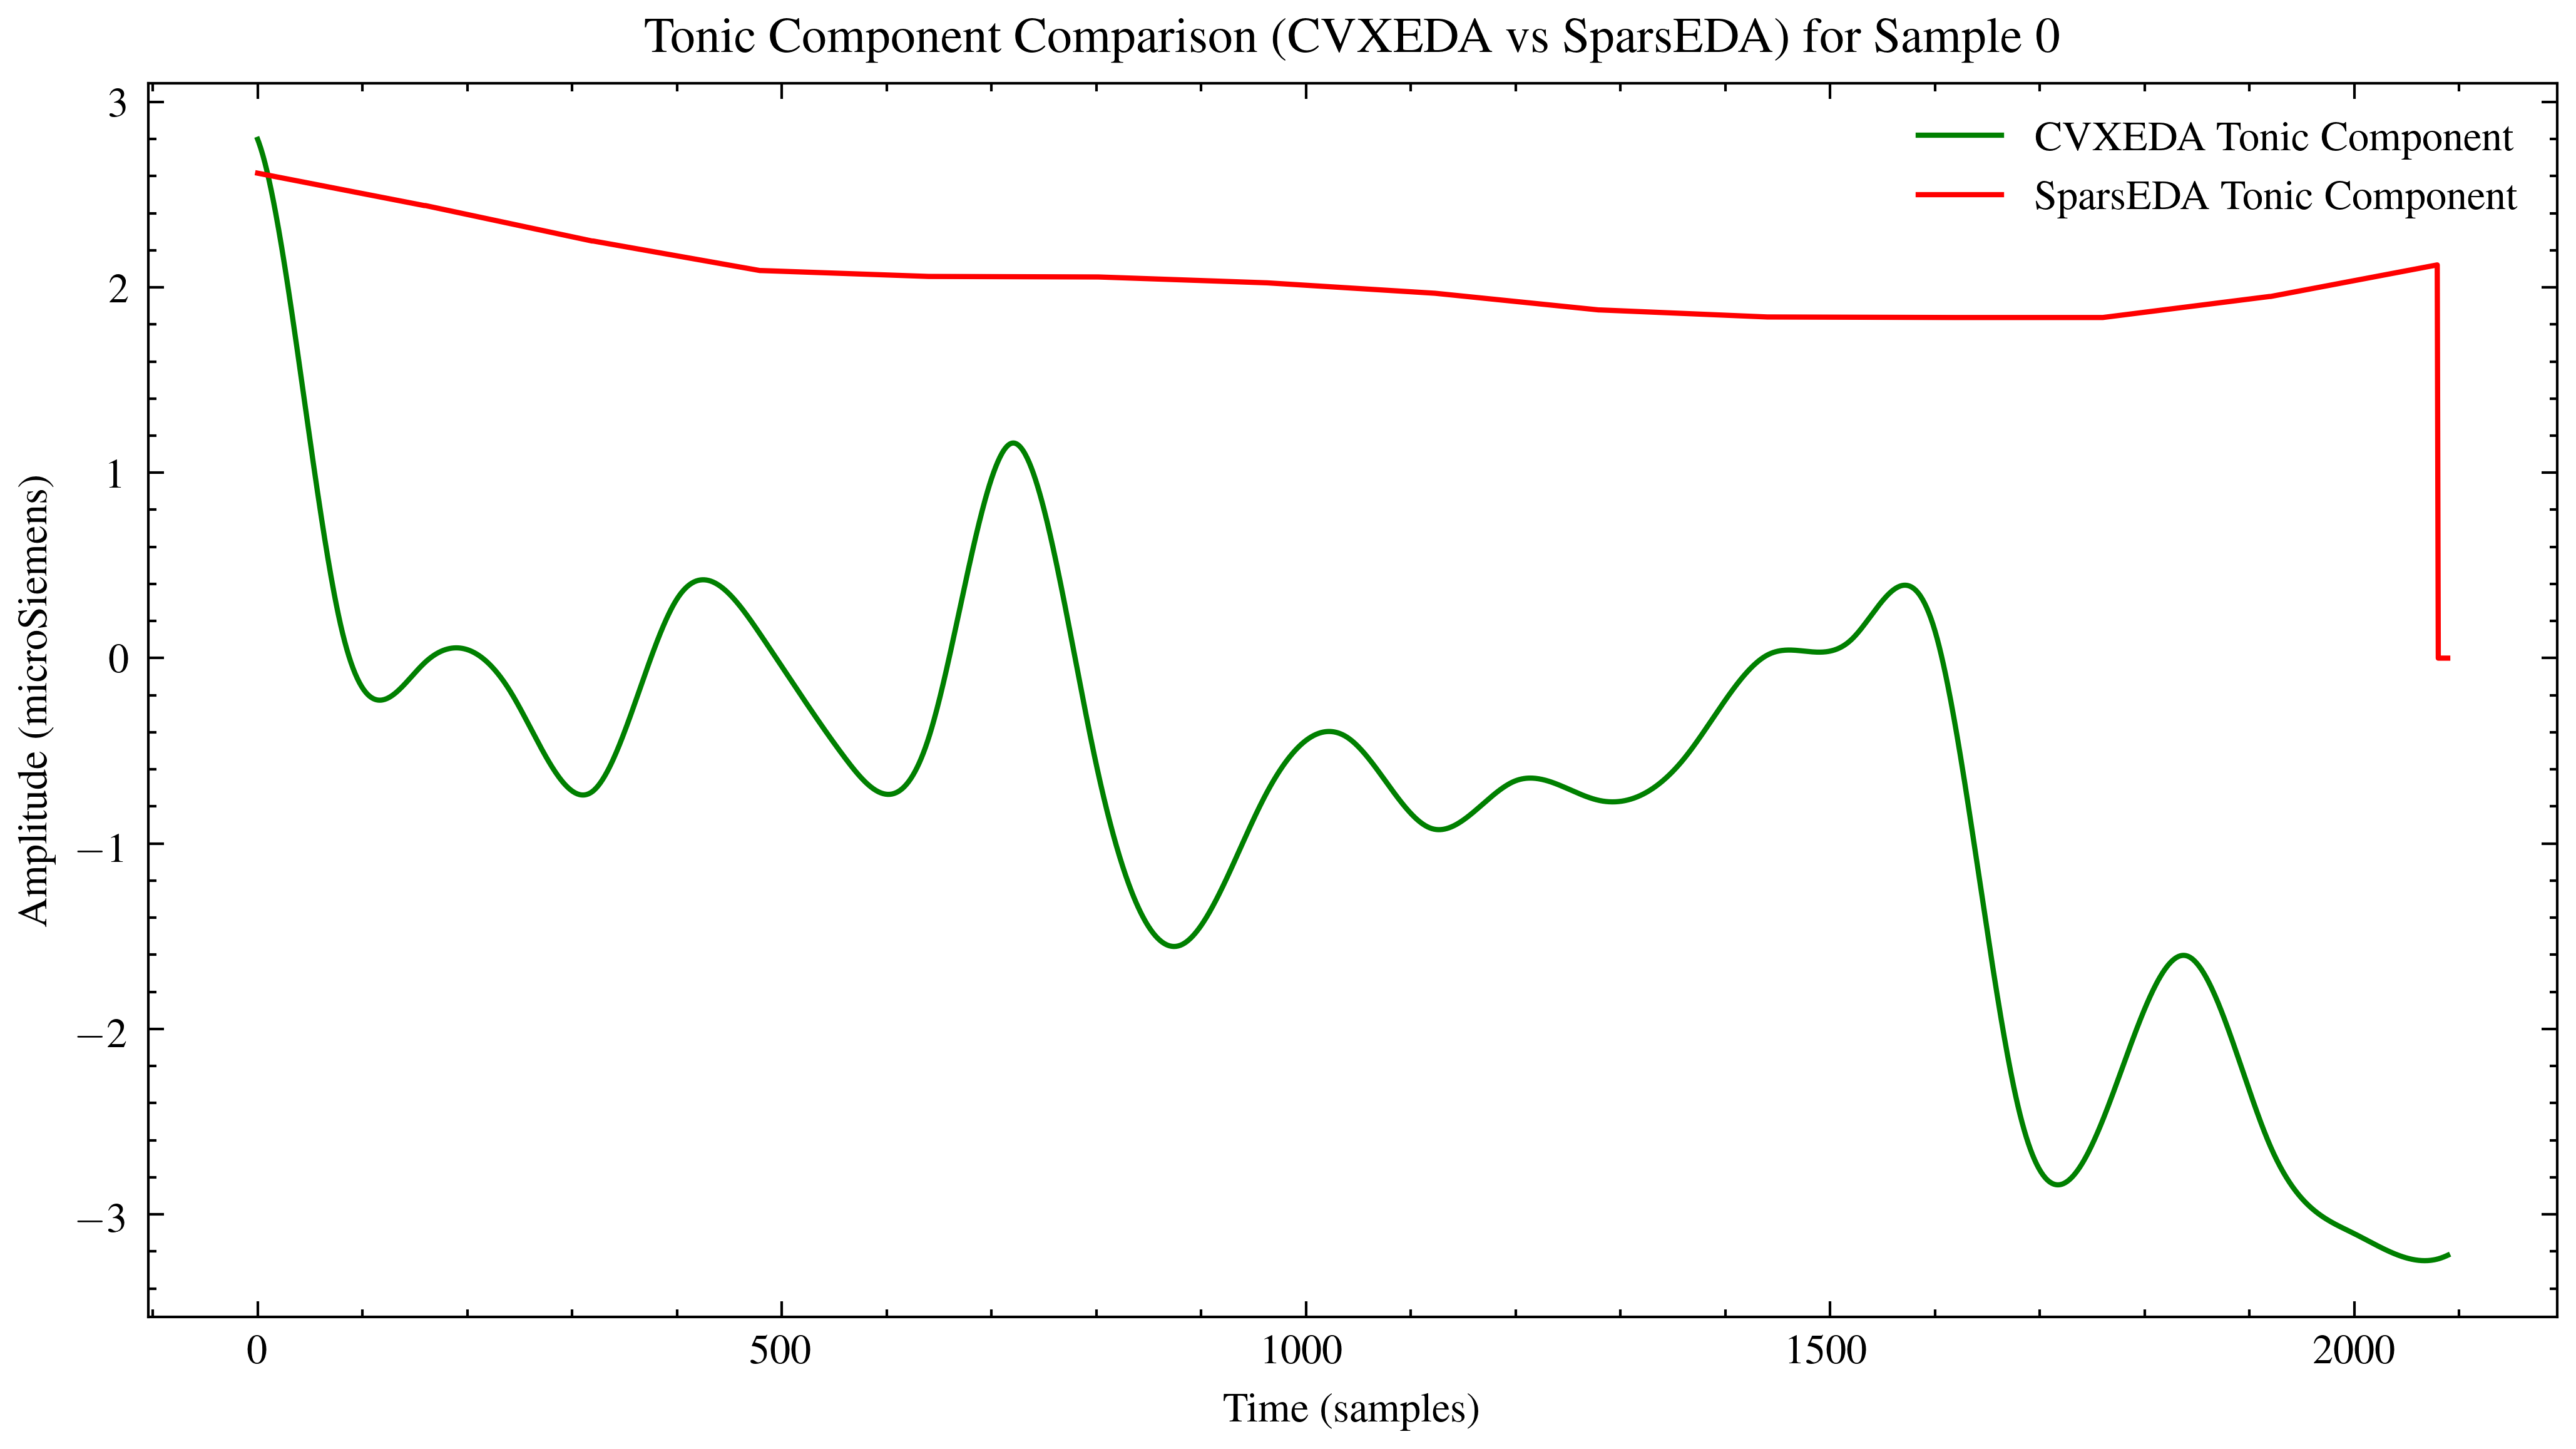

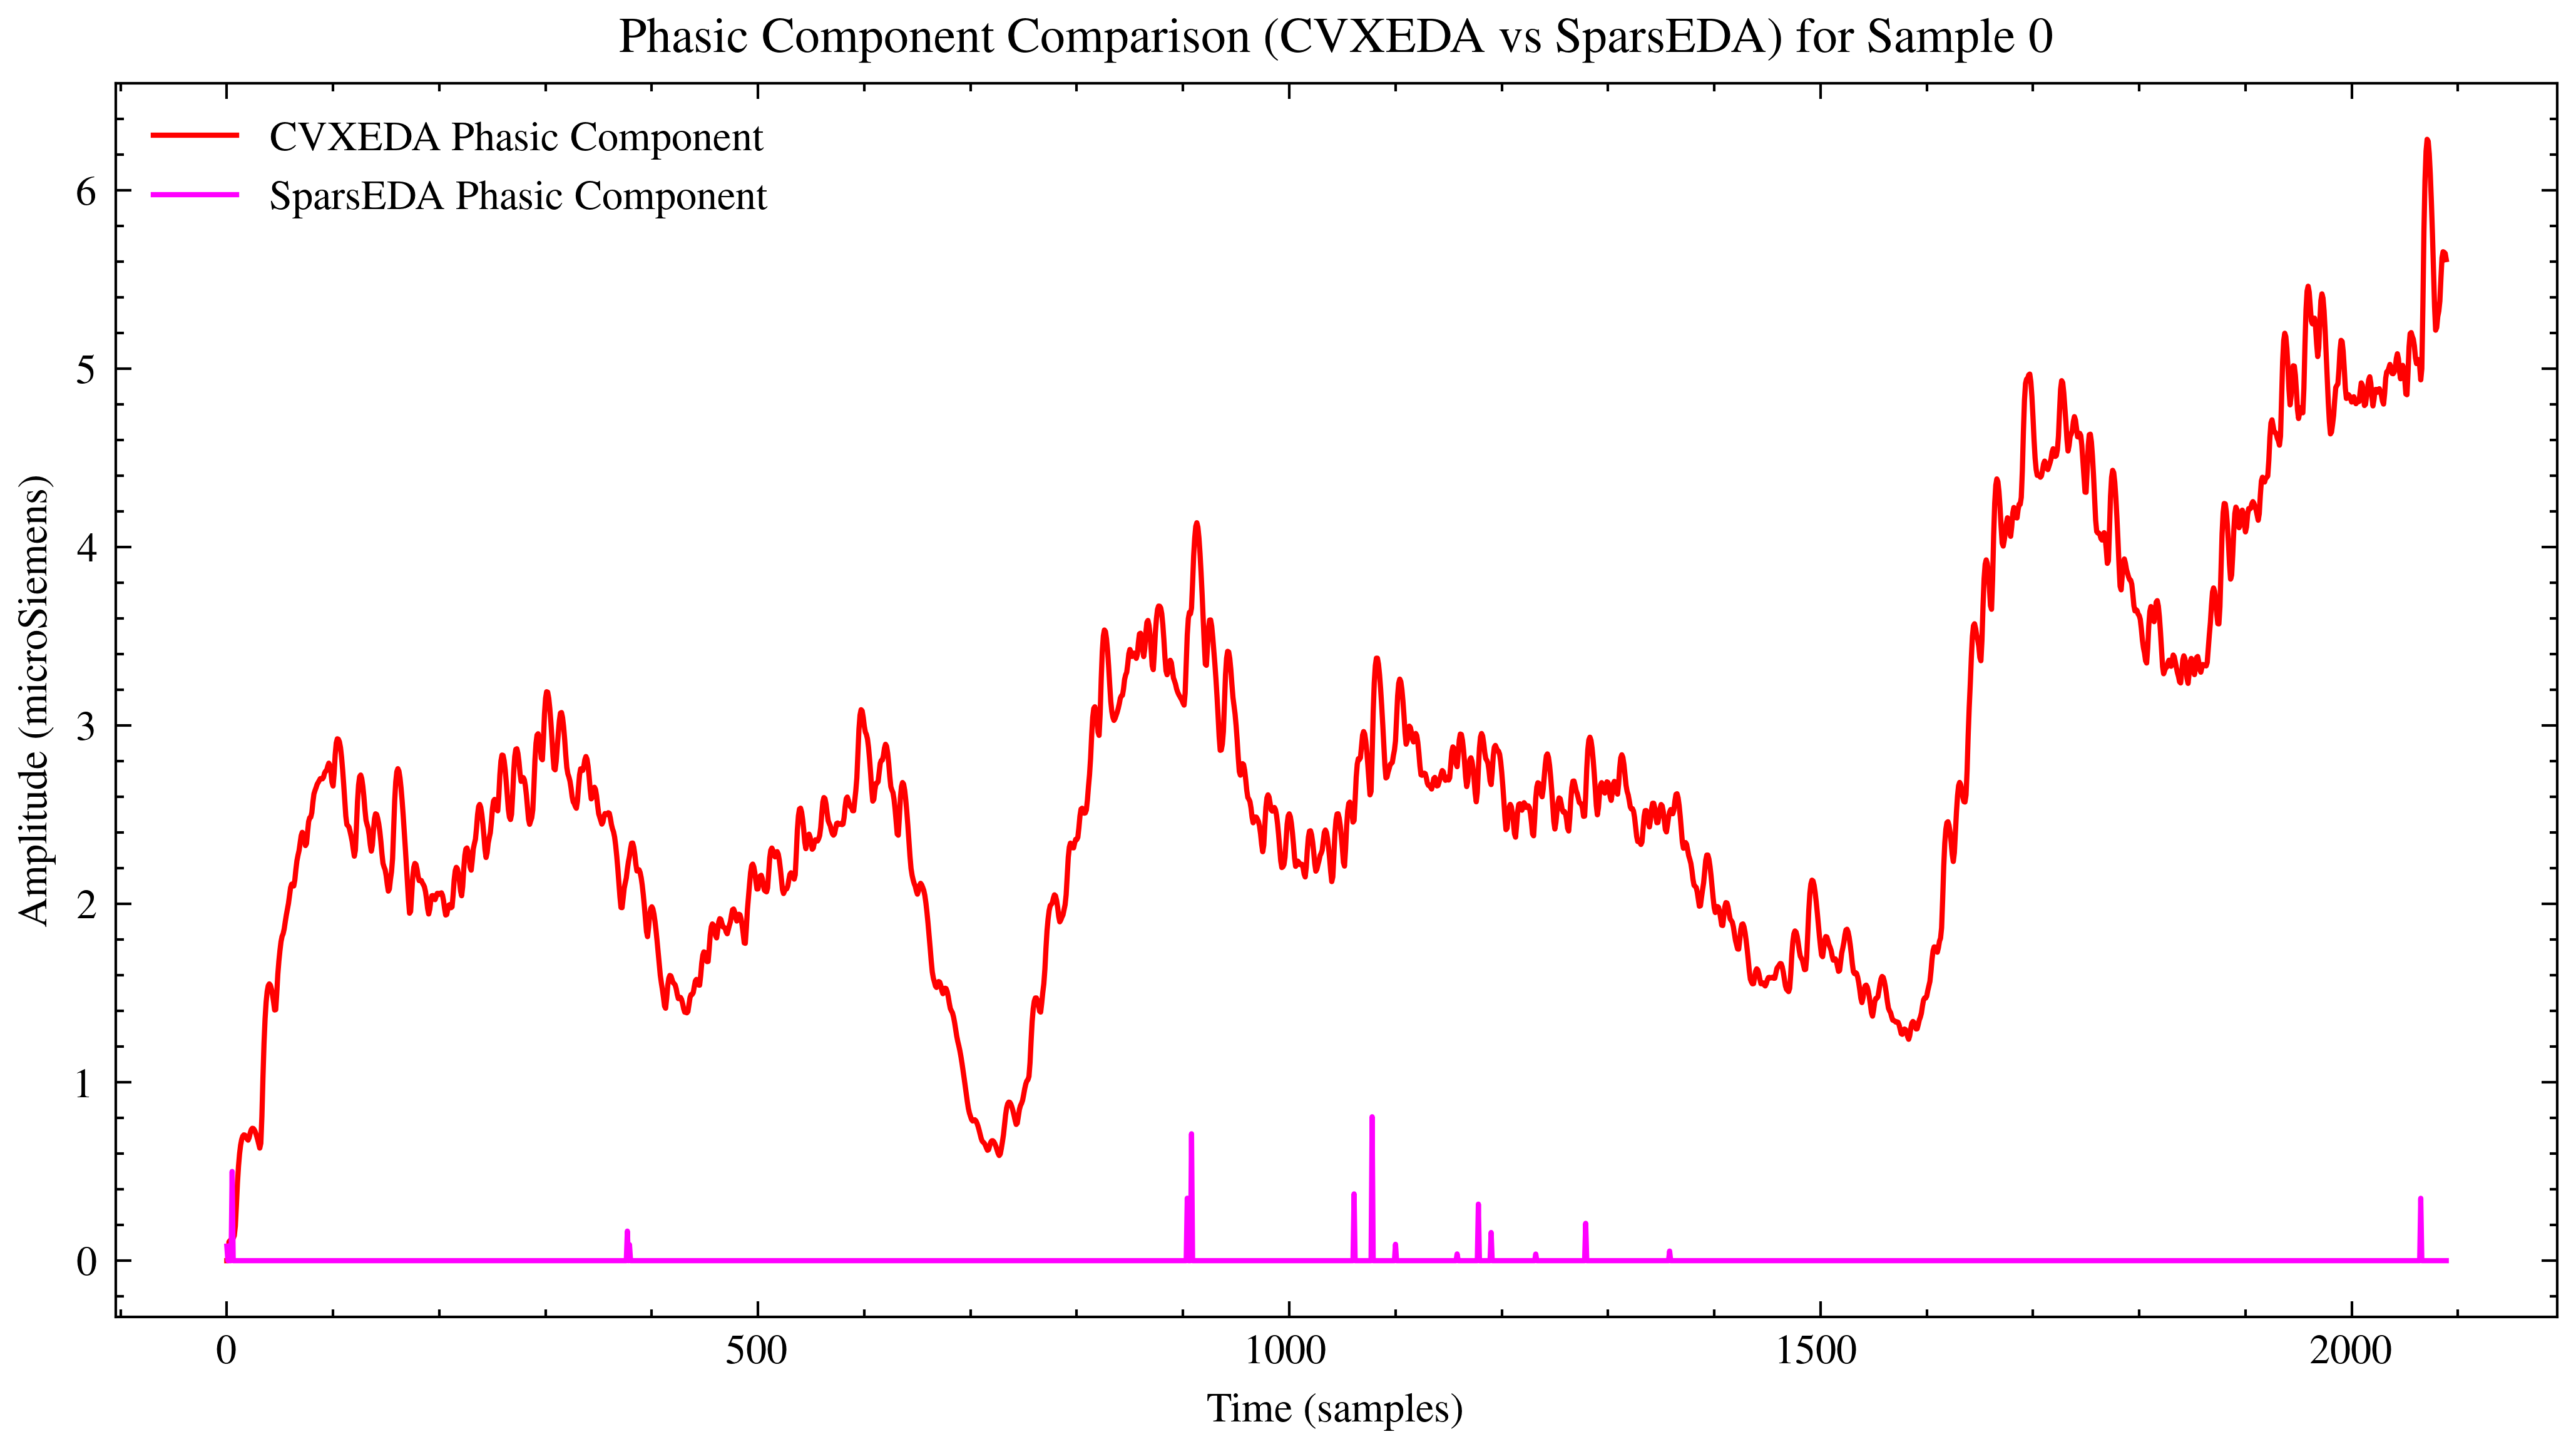


Evaluation Results:
Mean Squared Error (Tonic Component): CVXEDA vs SparsEDA: 8.7960
Mean Squared Error (Phasic Component): CVXEDA vs SparsEDA: 8.6105
Sparsity (Phasic Component) - CVXEDA: 0.9990, SparsEDA: 0.0077


In [25]:
import matplotlib.pyplot as plt
import pywt
import json
import numpy as np
import pandas as pd
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import os
import random
import scienceplots  # Ensure scienceplots is installed
from sklearn.metrics import mean_squared_error

# Use IEEE scienceplot style
plt.style.use(['science', 'ieee'])

# Wavelet denoising function
def wavelet_denoise_gsr_signal(gsr_data, wavelet='db4', artifact_proportion=0.01):
    # Ensure that the length of the data is even
    if len(gsr_data) % 2 != 0:
        gsr_data = gsr_data[:-1]  # Trim the last element if the length is odd

    # Calculate maximum level for wavelet decomposition based on the length of the data
    max_level = pywt.swt_max_level(len(gsr_data))

    # Perform stationary wavelet transform (SWT)
    coeffs = pywt.swt(gsr_data, wavelet, level=max_level)

    # Separate the detail coefficients and apply adaptive thresholding
    denoised_coeffs = []
    for cA, cD in coeffs:  # Extract both approximation and detail coefficients
        # Fit Gaussian to coefficients and compute adaptive threshold based on SURE
        mu, std = np.mean(cD), np.std(cD)
        threshold = std * np.sqrt(2 * np.log(len(cD)))

        # Apply soft thresholding to remove motion artifacts
        cD_thresholded = pywt.threshold(cD, threshold, mode='soft')

        # Append approximation coefficients and thresholded details
        denoised_coeffs.append((cA, cD_thresholded))

    # Reconstruct the signal using inverse stationary wavelet transform (ISWT)
    denoised_signal = pywt.iswt(denoised_coeffs, wavelet)

    return denoised_signal

# GSR signal preprocessing using wavelet denoising
def preprocess_gsr_signal(gsr_data, use_wavelet_denoising=True):
    if use_wavelet_denoising:
        gsr_data = wavelet_denoise_gsr_signal(gsr_data)
    return gsr_data

# Function to convert resistance (Ohms) to conductance (microSiemens)
def convert_to_microsiemens(gsr_data):
    return (1 / gsr_data) * 1e5

# Function to plot GSR signals with IEEE style
def plot_gsr_comparison(raw_gsr_data, denoised_gsr_data, phasic_cvxeda, tonic_cvxeda, driver_sparseda, SCL_sparseda, sample_idx=0):
    # First Figure: Raw and Wavelet-Denoised Signals
    plt.figure(figsize=(7, 5))

    # Plot raw GSR signal
    plt.subplot(2, 1, 1)
    plt.plot(raw_gsr_data, label='Raw GSR Signal', color='black')
    plt.title(f'Raw GSR Signal for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (Ohms)')
    plt.legend()

    # Plot wavelet-denoised GSR signal
    plt.subplot(2, 1, 2)
    plt.plot(denoised_gsr_data, label='Wavelet-Denoised GSR Signal', color='blue')
    plt.title(f'Wavelet-Denoised GSR Signal for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'raw_vs_wavelet_{sample_idx}.png', dpi=300)
    plt.show()

    # Second Figure: Tonic Components Comparison (CVXEDA vs SparsEDA)
    plt.figure(figsize=(7, 4))
    plt.plot(tonic_cvxeda, label='CVXEDA Tonic Component', color='green')
    plt.plot(SCL_sparseda, label='SparsEDA Tonic Component', color='red', linestyle='-')
    plt.title(f'Tonic Component Comparison (CVXEDA vs SparsEDA) for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tonic_comparison_{sample_idx}.png', dpi=300)
    plt.show()

    # Third Figure: Phasic Components Comparison (CVXEDA vs SparsEDA)
    plt.figure(figsize=(7, 4))
    plt.plot(phasic_cvxeda, label='CVXEDA Phasic Component', color='red')
    plt.plot(driver_sparseda, label='SparsEDA Phasic Component', color='magenta', linestyle='-')
    plt.title(f'Phasic Component Comparison (CVXEDA vs SparsEDA) for Sample {sample_idx}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phasic_comparison_{sample_idx}.png', dpi=300)
    plt.show()

# Function to evaluate SparsEDA vs CVXEDA
def evaluate_sparseda_vs_cvxeda(tonic_cvxeda, phasic_cvxeda, SCL_sparseda, driver_sparseda):
    # Calculate MSE for Tonic Components
    mse_tonic = mean_squared_error(tonic_cvxeda, SCL_sparseda)
    
    # Calculate MSE for Phasic Components
    mse_phasic = mean_squared_error(phasic_cvxeda, driver_sparseda)

    # Sparsity calculation for phasic components
    sparsity_cvxeda = np.sum(phasic_cvxeda != 0) / len(phasic_cvxeda)
    sparsity_sparseda = np.sum(driver_sparseda != 0) / len(driver_sparseda)

    # Print Evaluation Results
    print("\nEvaluation Results:")
    print(f"Mean Squared Error (Tonic Component): CVXEDA vs SparsEDA: {mse_tonic:.4f}")
    print(f"Mean Squared Error (Phasic Component): CVXEDA vs SparsEDA: {mse_phasic:.4f}")
    print(f"Sparsity (Phasic Component) - CVXEDA: {sparsity_cvxeda:.4f}, SparsEDA: {sparsity_sparseda:.4f}")

    # Return results for further use if needed
    return {
        "mse_tonic": mse_tonic,
        "mse_phasic": mse_phasic,
        "sparsity_cvxeda": sparsity_cvxeda,
        "sparsity_sparseda": sparsity_sparseda
    }

# Function to process and plot GSR signals
def process_player_data_and_plot(player_path, match_folder, player_folder):
    heart_rate_file = os.path.join(player_path, "heart_rate.csv")
    gsr_file = os.path.join(player_path, "gsr.csv")
    mental_load_file = os.path.join(player_path, "player_report.json")

    if os.path.exists(heart_rate_file) and os.path.exists(gsr_file) and os.path.exists(mental_load_file):
        df_gsr = pd.read_csv(gsr_file)
        gsr_data = df_gsr['gsr'].values

        # Convert GSR from resistance (Ohms) to conductance (microSiemens)
        gsr_data = convert_to_microsiemens(gsr_data)

        # Preprocess GSR with wavelet denoising
        denoised_gsr_data = preprocess_gsr_signal(gsr_data)

        # Decompose the denoised signal using CVXEDA and SparsEDA
        sampling_rate = 8  # Assume the GSR data is sampled at 2 Hz
        delta = 1 / sampling_rate  # Adjust delta based on sampling rate
        phasic_cvxeda, _, tonic_cvxeda, _, _, _, _ = cvxEDA(denoised_gsr_data, delta=delta)

        # SparsEDA: Fine-tune parameters for better event detection
        sr = 8  # Ensure the same sampling rate for SparsEDA
        epsilon = 0.0001  # Control the precision; decrease for finer detail
        Kmax = 40  # Increase max iterations for smoother convergence
        dmin = 1.25 # Minimum time between events (in seconds), adjust for better sensitivity
        rho = 0.025  # Reduce to maintain more activity (less sparsity)

        # Decompose GSR signal using SparsEDA
        driver_sparseda, SCL_sparseda, _ = sparsEDA(denoised_gsr_data, sr, epsilon, Kmax, dmin, rho)

        # Plot GSR signals (raw, denoised, and decomposed)
        plot_gsr_comparison(gsr_data, denoised_gsr_data, phasic_cvxeda, tonic_cvxeda, driver_sparseda, SCL_sparseda)

        # Perform evaluation and print results
        evaluate_sparseda_vs_cvxeda(tonic_cvxeda, phasic_cvxeda, SCL_sparseda, driver_sparseda)

    else:
        print(f"Missing files for player data in {player_path}")

# Helper function to get random player path
def get_random_player_path(base_dir):
    match_dir = os.path.join(base_dir, "matches")
    
    # Get all match folders
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]
    
    if not match_folders:
        raise FileNotFoundError("No match folders found in the directory")

    # Randomly select a match folder
    random_match_folder = random.choice(match_folders)
    
    # Get all player folders within the selected match folder
    player_dir = os.path.join(match_dir, random_match_folder)
    player_folders = [f for f in os.listdir(player_dir) if os.path.isdir(os.path.join(player_dir, f)) and "player_" in f]
    
    if not player_folders:
        raise FileNotFoundError(f"No player folders found in match folder: {random_match_folder}")

    # Randomly select a player folder
    random_player_folder = random.choice(player_folders)

    player_path = os.path.join(player_dir, random_player_folder)
    
    return player_path, random_match_folder, random_player_folder

# Main script execution
if __name__ == "__main__":
    base_dir = r"D:\eSports_Sensors_Dataset-master"

    # Get random player path and folder names
    player_path, match_folder, player_folder = get_random_player_path(base_dir)
    
    print(f"Randomly selected player path: {player_path}")
    print(f"Random match folder: {match_folder}")
    print(f"Random player folder: {player_folder}")
    
    # Call the function to process player data and plot
    process_player_data_and_plot(player_path, match_folder, player_folder)


Randomly selected player path: D:\eSports_Sensors_Dataset-master\matches\match_8\player_3
Random match folder: match_8
Random player folder: player_3


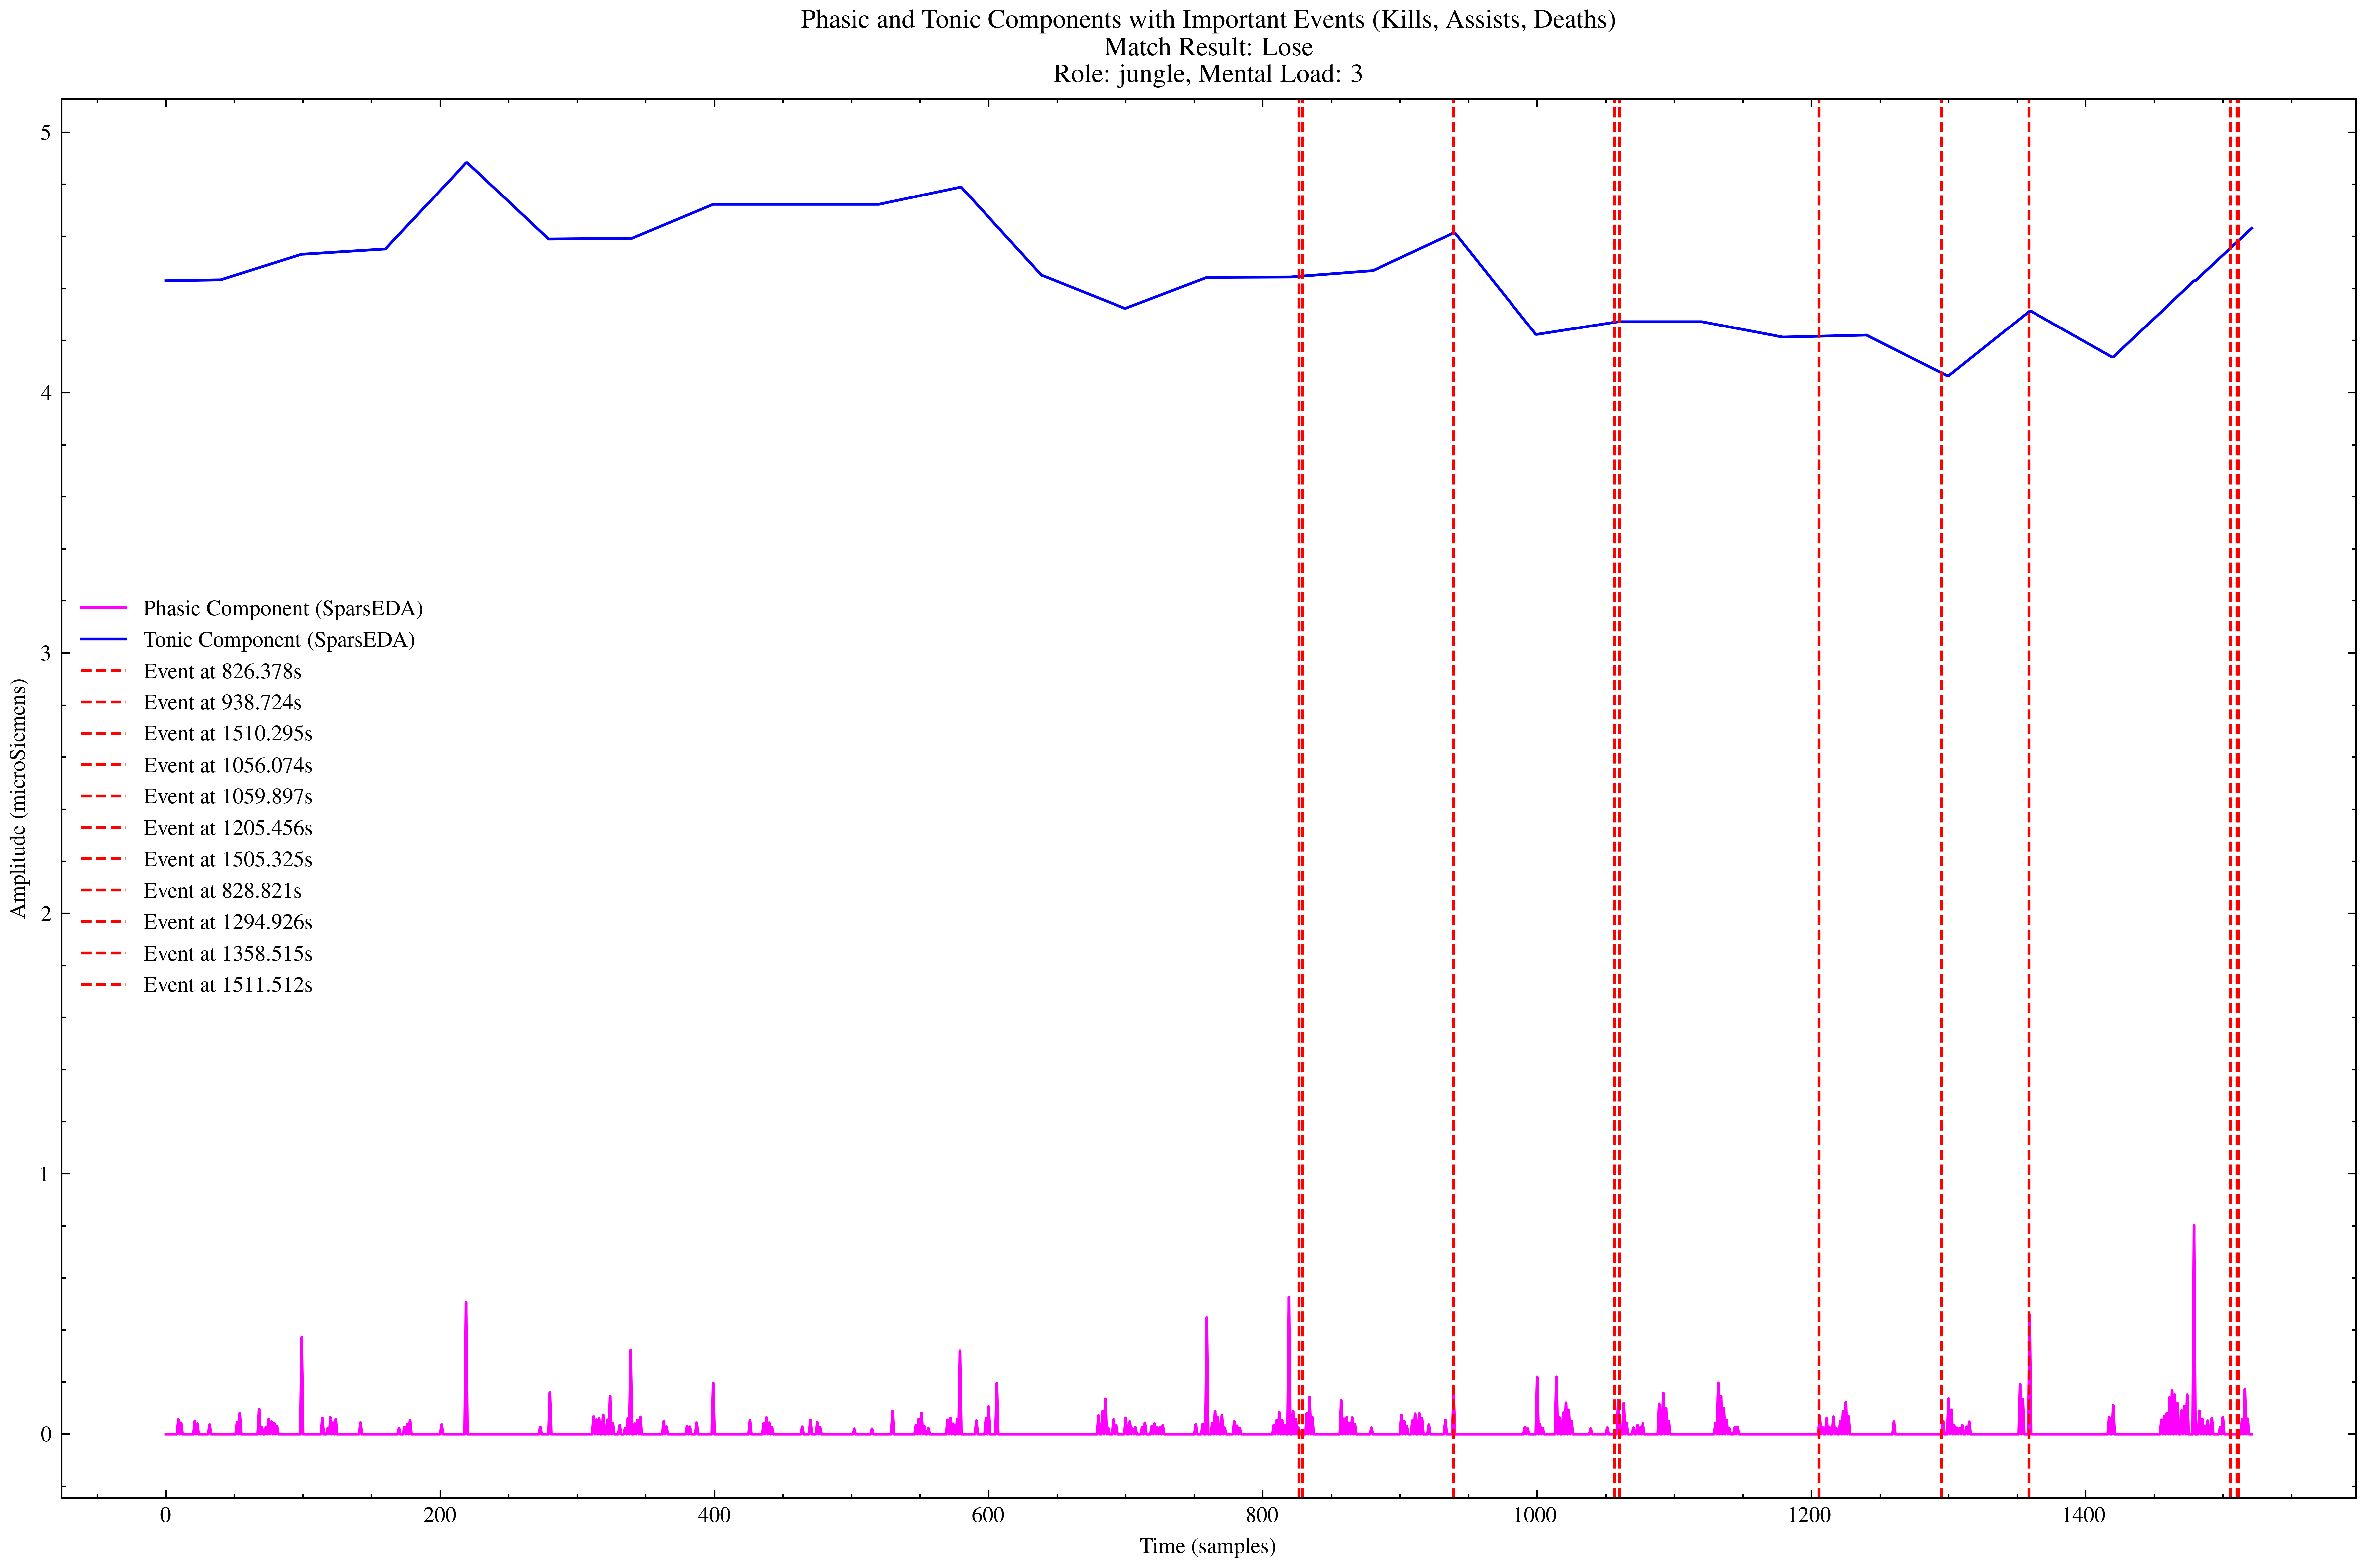

In [27]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import random
import scienceplots
from scipy.interpolate import interp1d

# Use IEEE scienceplot style for academic styling
plt.style.use(['science', 'ieee'])

# Load replay data
def load_replay_data(replay_file_path):
    with open(replay_file_path, 'r') as file:
        replay_data = json.load(file)
    return replay_data

# Load player report data
def load_player_report(player_report_path):
    with open(player_report_path, 'r') as file:
        player_report = json.load(file)
    return player_report

# Determine if the player won or lost
def determine_player_result(player_id, replay_data):
    team_data = replay_data.get("teams", {})
    player_team_id = 100 if player_id in team_data["participants"]["players"] else 200
    match_result = team_data["participants"]["win"] if player_team_id == 100 else team_data["opponents"]["win"]
    return "Win" if match_result == "Win" else "Lose"

# Plot Phasic and Tonic Components with Important Events
def plot_phasic_tonic_with_events(phasic_signal, tonic_signal, event_times, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(12, 8))
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    for event_time in event_times:
        plt.axvline(x=event_time * sampling_rate, color='red', linestyle='--', label=f'Event at {event_time}s')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Important Events (Kills, Assists, Deaths)\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phasic_tonic_events_{player_folder}.png', dpi=300)
    plt.show()

# Plot Timeline Overview of Replay Events
def plot_timeline_overview(replay_data, player_data, phasic_signal, tonic_signal, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(20, 30))

    # Plot phasic and tonic signals
    plt.subplot(6, 1, 1)
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Timeline Overview\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()

    # Extract data from replay
    original_timestamps = [entry['timestamp'] for entry in player_data['timelineStats']]
    original_total_gold = [entry['totalGold'] for entry in player_data['timelineStats']]
    total_damage_dealt = [entry.get('totalDamageDealt', 0) for entry in player_data['timelineStats']]
    total_damage_taken = [entry.get('totalDamageTaken', 0) for entry in player_data['timelineStats']]
    xp = [entry.get('xp', 0) for entry in player_data['timelineStats']]
    current_gold = [entry.get('currentGold', 0) for entry in player_data['timelineStats']]
    level = [entry.get('level', 0) for entry in player_data['timelineStats']]

    # Resample timestamps and interpolate values to match GSR data length
    gsr_length = len(phasic_signal)
    max_timestamp = original_timestamps[-1]
    resampled_timestamps = np.linspace(0, max_timestamp, gsr_length)

    # Interpolate all relevant parameters to match the new timestamps
    interpolator_gold = interp1d(original_timestamps, original_total_gold, kind='linear', fill_value='extrapolate')
    interpolator_damage = interp1d(original_timestamps, total_damage_dealt, kind='linear', fill_value='extrapolate')
    interpolator_taken = interp1d(original_timestamps, total_damage_taken, kind='linear', fill_value='extrapolate')
    interpolator_xp = interp1d(original_timestamps, xp, kind='linear', fill_value='extrapolate')
    interpolator_current_gold = interp1d(original_timestamps, current_gold, kind='linear', fill_value='extrapolate')
    interpolator_level = interp1d(original_timestamps, level, kind='linear', fill_value='extrapolate')

    resampled_total_gold = interpolator_gold(resampled_timestamps)
    resampled_total_damage = interpolator_damage(resampled_timestamps)
    resampled_total_taken = interpolator_taken(resampled_timestamps)
    resampled_xp = interpolator_xp(resampled_timestamps)
    resampled_current_gold = interpolator_current_gold(resampled_timestamps)
    resampled_level = interpolator_level(resampled_timestamps)

    # Plot total gold earned, current gold, kills, assists, and deaths
    plt.subplot(6, 1, 2)
    plt.plot(resampled_timestamps, resampled_total_gold, label='Total Gold Earned', color='gold', linestyle='-')
    plt.plot(resampled_timestamps, resampled_current_gold, label='Current Gold', color='orange', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gold')
    plt.title('Total Gold Earned and Current Gold Over Time')
    plt.legend()

    # Plot kills, assists, and deaths
    kills = player_data['killTimes']
    assists = player_data['assistTimes']
    deaths = player_data['deathTimes']

    for kill_time in kills:
        plt.axvline(x=kill_time, color='green', linestyle='-', label='Kill')
    for assist_time in assists:
        plt.axvline(x=assist_time, color='blue', linestyle='--', label='Assist')
    for death_time in deaths:
        plt.axvline(x=death_time, color='black', linestyle='-.', label='Death')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Events')
    plt.title('Kills, Assists, and Deaths Over Time')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'timeline_overview_player_{player_folder}.png', dpi=300)
    plt.show()

# Function to process player data and analyze replay events
def process_player_data_and_analyze_events(player_path, replay_file_path, match_folder, player_folder):
    # Load replay data
    replay_data = load_replay_data(replay_file_path)
    player_data = replay_data.get('player_0', {})

    # Load player report
    player_report_path = os.path.join(player_path, "player_report.json")
    if not os.path.exists(player_report_path):
        print(f"Missing player report for player in {player_path}")
        return
    player_report = load_player_report(player_report_path)

    # Get important event times
    kill_times = player_data.get('killTimes', [])
    assist_times = player_data.get('assistTimes', [])
    death_times = player_data.get('deathTimes', [])
    event_times = kill_times + assist_times + death_times

    # Load GSR data
    gsr_file = os.path.join(player_path, "gsr.csv")
    if not os.path.exists(gsr_file):
        print(f"Missing GSR data for player in {player_path}")
        return

    df_gsr = pd.read_csv(gsr_file)
    gsr_data = df_gsr['gsr'].values

    # Convert GSR from resistance (Ohms) to conductance (microSiemens)
    gsr_data = (1 / gsr_data) * 1e5

    # Preprocess GSR with wavelet denoising
    gsr_data = wavelet_denoise_gsr_signal(gsr_data)

    # Decompose GSR using SparsEDA
    sampling_rate = 1  # Assume the GSR data is sampled at 1 Hz
    epsilon = 0.0001
    Kmax = 40
    dmin = 1.25
    rho = 0.025
    driver_sparseda, SCL_sparseda, _ = sparsEDA(gsr_data, sampling_rate, epsilon, Kmax, dmin, rho)

    # Determine match result
    player_id = 0  # Assuming player_0
    match_result = determine_player_result(player_id, replay_data)

    # Plot phasic and tonic components with event markers
    plot_phasic_tonic_with_events(driver_sparseda, SCL_sparseda, event_times, sampling_rate, player_folder, match_result, player_report)

    # Plot timeline overview with player activity
    plot_timeline_overview(replay_data, player_data, driver_sparseda, SCL_sparseda, sampling_rate, player_folder, match_result, player_report)

def get_random_player_path(base_dir):
    match_dir = os.path.join(base_dir, "matches")
    
    # Get all match folders
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]
    
    if not match_folders:
        raise FileNotFoundError("No match folders found in the directory")

    # Randomly select a match folder
    random_match_folder = random.choice(match_folders)
    
    # Get all player folders within the selected match folder
    player_dir = os.path.join(match_dir, random_match_folder)
    player_folders = [f for f in os.listdir(player_dir) if os.path.isdir(os.path.join(player_dir, f)) and "player_" in f]
    
    if not player_folders:
        raise FileNotFoundError(f"No player folders found in match folder: {random_match_folder}")

    # Randomly select a player folder
    random_player_folder = random.choice(player_folders)

    player_path = os.path.join(player_dir, random_player_folder)
    
    return player_path, random_match_folder, random_player_folder

# Main script execution
if __name__ == "__main__":
    base_dir = r"D:\eSports_Sensors_Dataset-master"
    replay_file_path = r"D:\eSports_Sensors_Dataset-master\matches\match_1\replay.json"

    # Get random player path and folder names
    player_path, match_folder, player_folder = get_random_player_path(base_dir)
    print(f"Randomly selected player path: {player_path}")
    print(f"Random match folder: {match_folder}")
    print(f"Random player folder: {player_folder}")

    # Call the function to process player data and analyze events
    process_player_data_and_analyze_events(player_path, replay_file_path, match_folder, player_folder)


GSR Analysis Results:
Error processing D:\eSports_Sensors_Dataset-master\matches\match_6\player_4: Object of type bool_ is not JSON serializable
GSR Analysis Results:
Error processing D:\eSports_Sensors_Dataset-master\matches\match_3\player_4: Object of type bool_ is not JSON serializable
GSR Analysis Results:
Error processing D:\eSports_Sensors_Dataset-master\matches\match_17\player_4: Object of type bool_ is not JSON serializable
GSR Analysis Results:
Error processing D:\eSports_Sensors_Dataset-master\matches\match_19\player_1: Object of type bool_ is not JSON serializable
GSR Analysis Results:
Error processing D:\eSports_Sensors_Dataset-master\matches\match_4\player_0: Object of type bool_ is not JSON serializable


KeyboardInterrupt: 

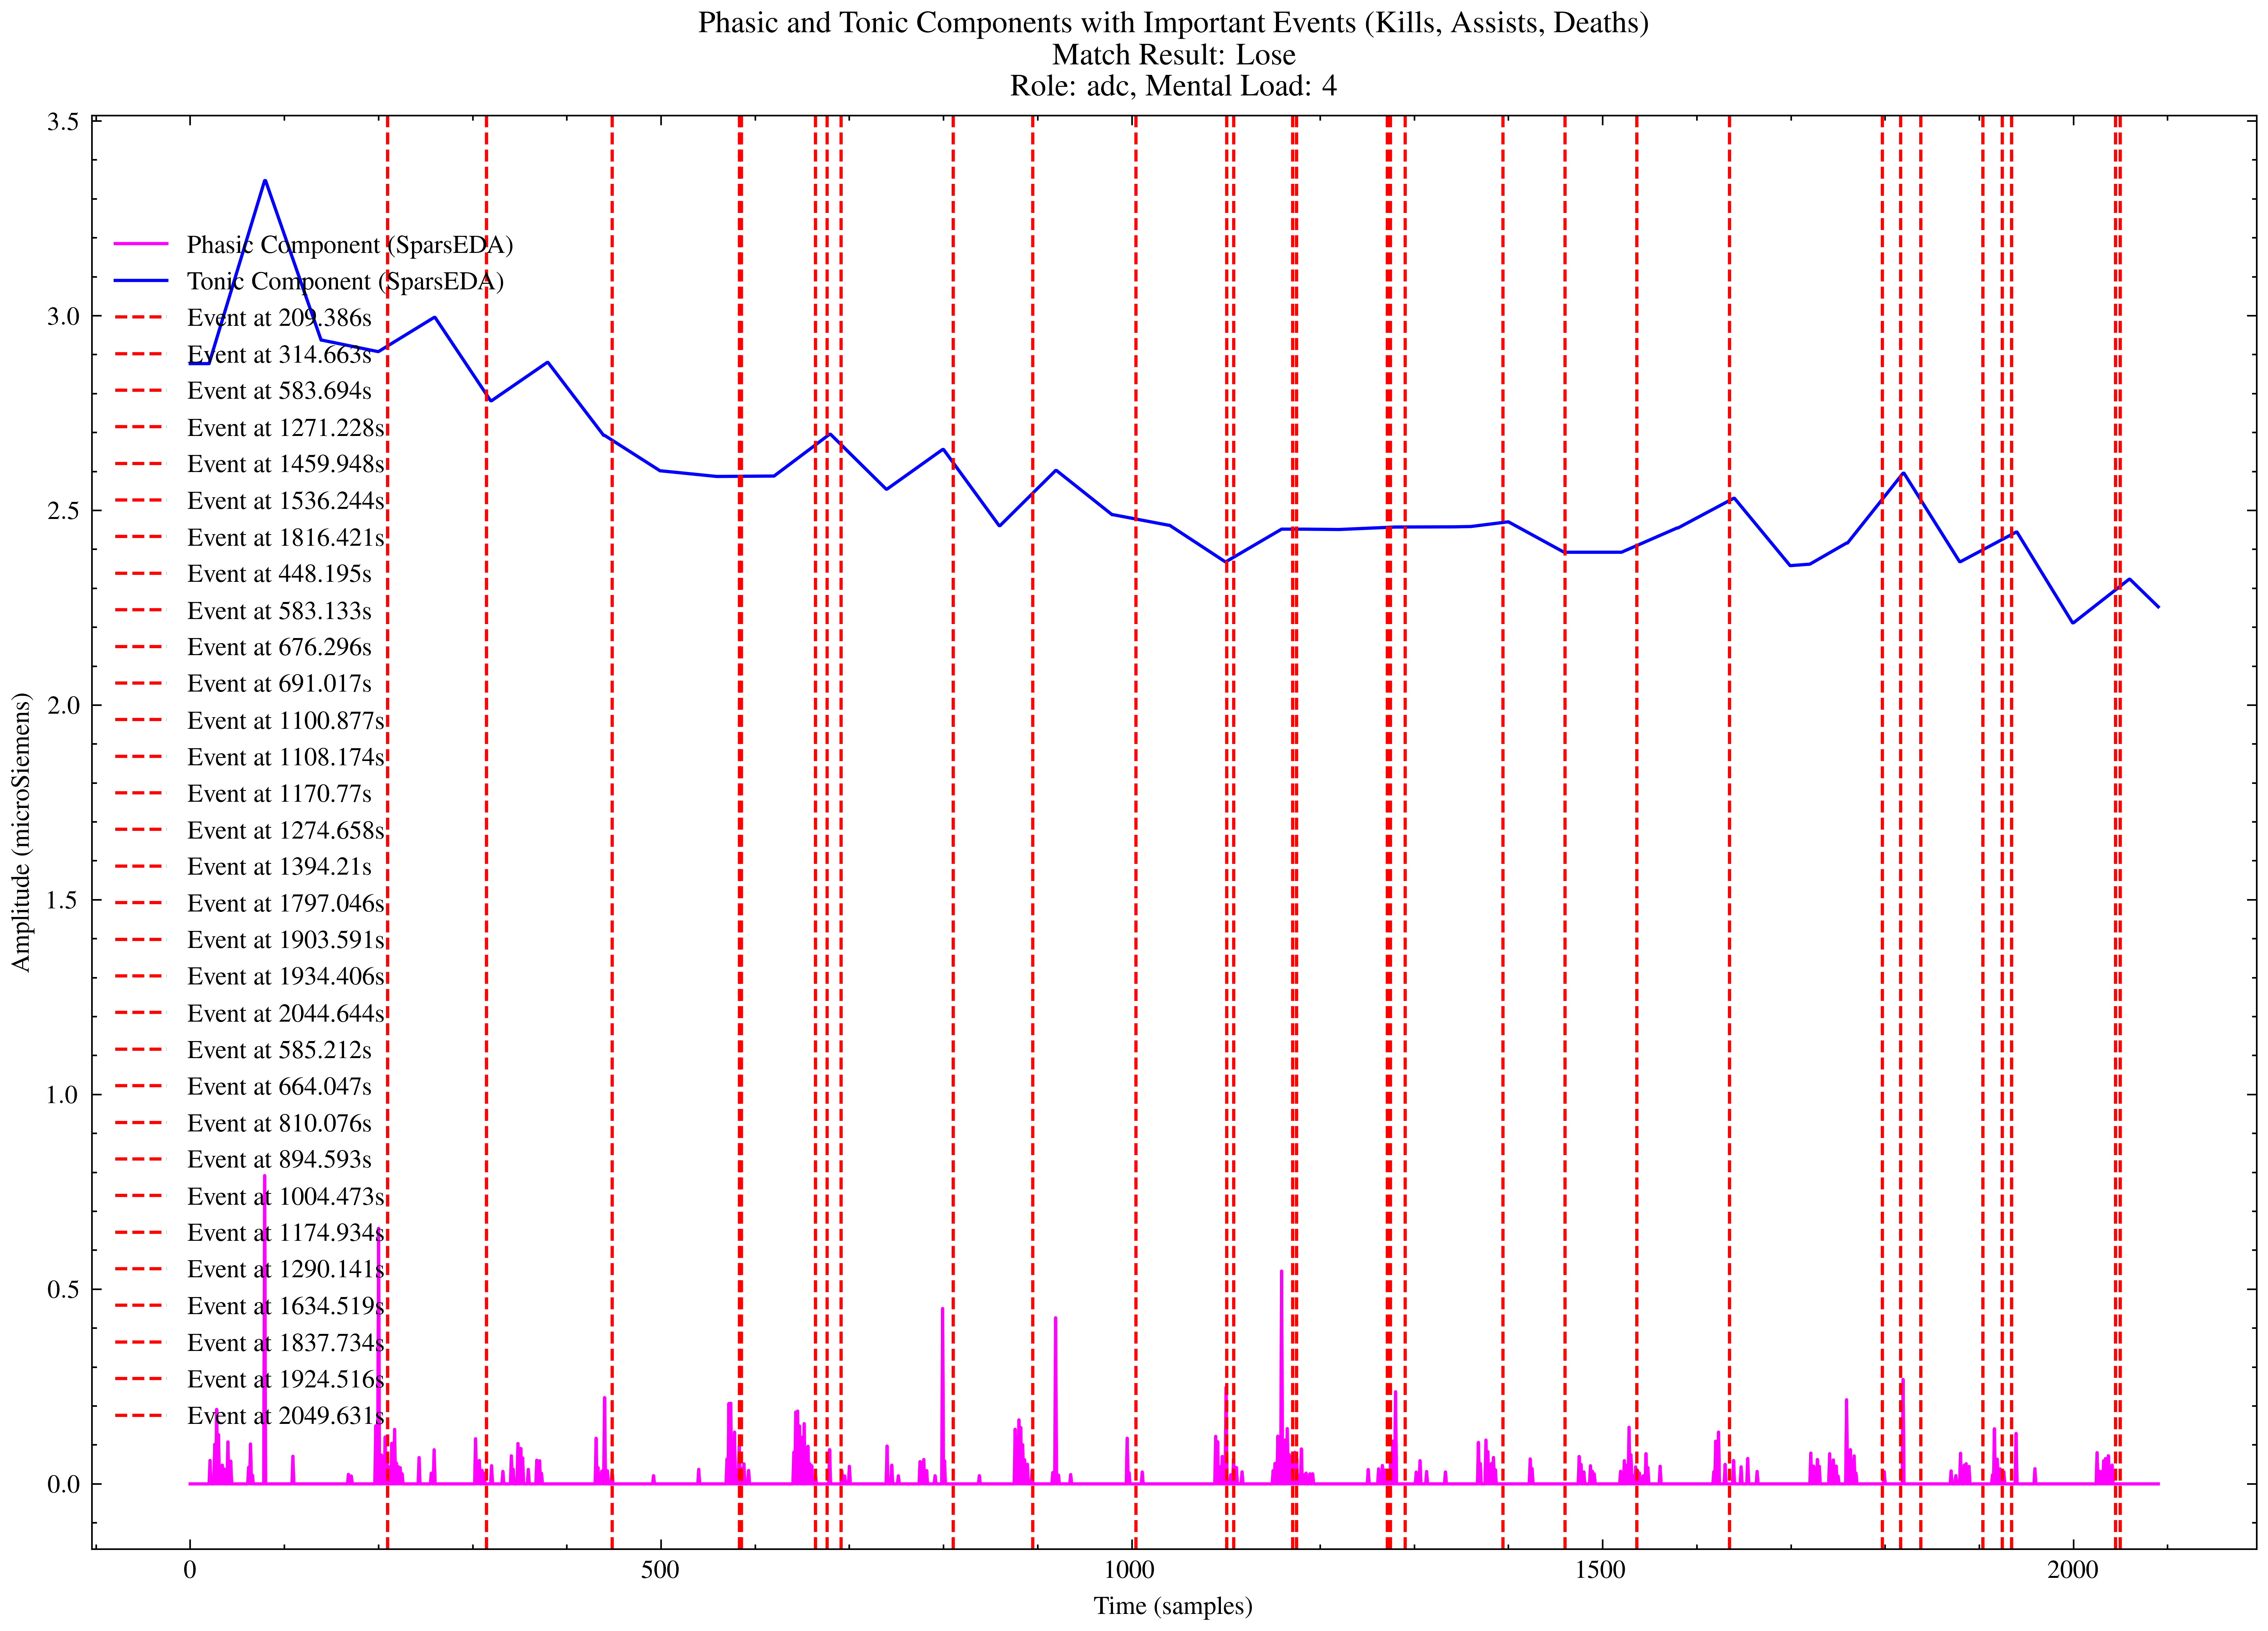

In [34]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import pearsonr, ttest_ind
from statsmodels.tsa.stattools import adfuller
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import random
import scienceplots
from scipy.interpolate import interp1d

# Use IEEE scienceplot style for academic styling
plt.style.use(['science', 'ieee'])

def numpy_to_python(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: numpy_to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_python(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(numpy_to_python(i) for i in obj)
    elif isinstance(obj, set):
        return {numpy_to_python(i) for i in obj}
    else:
        return obj

def load_replay_data(replay_file_path):
    with open(replay_file_path, 'r') as file:
        replay_data = json.load(file)
    return replay_data

def load_player_report(player_report_path):
    with open(player_report_path, 'r') as file:
        player_report = json.load(file)
    return player_report

def determine_player_result(player_id, replay_data):
    team_data = replay_data.get("teams", {})
    player_team_id = 100 if player_id in team_data["participants"]["players"] else 200
    match_result = team_data["participants"]["win"] if player_team_id == 100 else team_data["opponents"]["win"]
    return "Win" if match_result == "Win" else "Lose"

def plot_phasic_tonic_with_events(phasic_signal, tonic_signal, event_times, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(12, 8))
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    for event_time in event_times:
        plt.axvline(x=event_time * sampling_rate, color='red', linestyle='--', label=f'Event at {event_time}s')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Important Events (Kills, Assists, Deaths)\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phasic_tonic_events_{player_folder}.png', dpi=300)
    plt.close()

def plot_timeline_overview(replay_data, player_data, phasic_signal, tonic_signal, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(20, 30))

    # Plot phasic and tonic signals
    plt.subplot(6, 1, 1)
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Timeline Overview\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()

    # Extract data from replay
    original_timestamps = [entry['timestamp'] for entry in player_data['timelineStats']]
    original_total_gold = [entry['totalGold'] for entry in player_data['timelineStats']]
    total_damage_dealt = [entry.get('totalDamageDealt', 0) for entry in player_data['timelineStats']]
    total_damage_taken = [entry.get('totalDamageTaken', 0) for entry in player_data['timelineStats']]
    xp = [entry.get('xp', 0) for entry in player_data['timelineStats']]
    current_gold = [entry.get('currentGold', 0) for entry in player_data['timelineStats']]
    level = [entry.get('level', 0) for entry in player_data['timelineStats']]

    # Resample timestamps and interpolate values to match GSR data length
    gsr_length = len(phasic_signal)
    max_timestamp = original_timestamps[-1]
    resampled_timestamps = np.linspace(0, max_timestamp, gsr_length)

    # Interpolate all relevant parameters to match the new timestamps
    interpolator_gold = interp1d(original_timestamps, original_total_gold, kind='linear', fill_value='extrapolate')
    interpolator_damage = interp1d(original_timestamps, total_damage_dealt, kind='linear', fill_value='extrapolate')
    interpolator_taken = interp1d(original_timestamps, total_damage_taken, kind='linear', fill_value='extrapolate')
    interpolator_xp = interp1d(original_timestamps, xp, kind='linear', fill_value='extrapolate')
    interpolator_current_gold = interp1d(original_timestamps, current_gold, kind='linear', fill_value='extrapolate')
    interpolator_level = interp1d(original_timestamps, level, kind='linear', fill_value='extrapolate')

    resampled_total_gold = interpolator_gold(resampled_timestamps)
    resampled_total_damage = interpolator_damage(resampled_timestamps)
    resampled_total_taken = interpolator_taken(resampled_timestamps)
    resampled_xp = interpolator_xp(resampled_timestamps)
    resampled_current_gold = interpolator_current_gold(resampled_timestamps)
    resampled_level = interpolator_level(resampled_timestamps)

    # Plot total gold earned, current gold, kills, assists, and deaths
    plt.subplot(6, 1, 2)
    plt.plot(resampled_timestamps, resampled_total_gold, label='Total Gold Earned', color='gold', linestyle='-')
    plt.plot(resampled_timestamps, resampled_current_gold, label='Current Gold', color='orange', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gold')
    plt.title('Total Gold Earned and Current Gold Over Time')
    plt.legend()

    # Plot kills, assists, and deaths
    kills = player_data['killTimes']
    assists = player_data['assistTimes']
    deaths = player_data['deathTimes']

    for kill_time in kills:
        plt.axvline(x=kill_time, color='green', linestyle='-', label='Kill')
    for assist_time in assists:
        plt.axvline(x=assist_time, color='blue', linestyle='--', label='Assist')
    for death_time in deaths:
        plt.axvline(x=death_time, color='black', linestyle='-.', label='Death')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Events')
    plt.title('Kills, Assists, and Deaths Over Time')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'timeline_overview_player_{player_folder}.png', dpi=300)
    plt.close()

def analyze_gsr_data(phasic_signal, tonic_signal, event_times, sampling_rate, player_role, mental_load, match_result):
    # Convert event times to sample indices
    event_indices = [int(t * sampling_rate) for t in event_times]

    # 1. Correlation between Phasic Component and Game Events
    phasic_peaks, _ = find_peaks(phasic_signal, height=np.mean(phasic_signal) + np.std(phasic_signal))
    event_correlation = analyze_event_correlation(phasic_peaks, event_indices, len(phasic_signal))
    
    # 2. Tonic Component Trend Analysis
    tonic_trend = analyze_tonic_trend(tonic_signal)
    
    # 3. Role and Mental Load Analysis
    role_load_impact = analyze_role_and_load(phasic_signal, tonic_signal, player_role, mental_load)
    
    # 4. Match Result Analysis
    result_impact = analyze_match_result(phasic_signal, tonic_signal, match_result)
    
    # 5. Event Frequency and Timing Analysis
    event_distribution = analyze_event_distribution(event_indices, len(phasic_signal))
    
    # 6. Response Variability Analysis
    phasic_variability = analyze_variability(phasic_signal)
    
    # 7. Recovery Pattern Analysis
    recovery_patterns = analyze_recovery_patterns(phasic_signal, event_indices)
    
    # Compile and return results
    results = {
        "event_correlation": event_correlation,
        "tonic_trend": tonic_trend,
        "role_load_impact": role_load_impact,
        "result_impact": result_impact,
        "event_distribution": event_distribution,
        "phasic_variability": phasic_variability,
        "recovery_patterns": recovery_patterns
    }
    
    return results

def analyze_event_correlation(phasic_peaks, event_indices, signal_length):
    time_window = 10  # 10 seconds before and after each event
    correlation_scores = []
    
    for event in event_indices:
        start = max(0, event - time_window)
        end = min(signal_length, event + time_window)
        event_window = np.zeros(signal_length)
        event_window[start:end] = 1
        
        phasic_window = np.zeros(signal_length)
        phasic_window[phasic_peaks] = 1
        
        correlation, _ = pearsonr(event_window, phasic_window)
        correlation_scores.append(correlation)
    
    return np.mean(correlation_scores)

def analyze_tonic_trend(tonic_signal):
    # Perform Augmented Dickey-Fuller test to check for stationarity
    result = adfuller(tonic_signal)
    is_stationary = result[1] <= 0.05
    
    # Simple linear trend
    x = np.arange(len(tonic_signal))
    slope, _ = np.polyfit(x, tonic_signal, 1)
    
    return {"is_stationary": is_stationary, "trend_slope": slope}

def analyze_role_and_load(phasic_signal, tonic_signal, player_role, mental_load):
    phasic_mean = np.mean(phasic_signal)
    tonic_mean = np.mean(tonic_signal)
    phasic_std = np.std(phasic_signal)
    tonic_std = np.std(tonic_signal)
    
    return {
        "role": player_role,
        "mental_load": mental_load,
        "phasic_mean": phasic_mean,
        "tonic_mean": tonic_mean,
        "phasic_std": phasic_std,
        "tonic_std": tonic_std
    }

def analyze_match_result(phasic_signal, tonic_signal, match_result):
    # Analyze the last quarter of the signals
    last_quarter = len(phasic_signal) // 4
    phasic_end = phasic_signal[-last_quarter:]
    tonic_end = tonic_signal[-last_quarter:]
    
    phasic_trend = np.polyfit(range(last_quarter), phasic_end, 1)[0]
    tonic_trend = np.polyfit(range(last_quarter), tonic_end, 1)[0]
    
    return {
        "result": match_result,
        "end_phasic_trend": phasic_trend,
        "end_tonic_trend": tonic_trend
    }

def analyze_event_distribution(event_indices, signal_length):
    bins = 10
    hist, _ = np.histogram(event_indices, bins=bins, range=(0, signal_length))
    return hist.tolist()

def analyze_variability(phasic_signal):
    window_size = len(phasic_signal) // 10
    variability = []
    
    for i in range(0, len(phasic_signal), window_size):
        window = phasic_signal[i:i+window_size]
        variability.append(np.std(window))
    
    return variability

def analyze_recovery_patterns(phasic_signal, event_indices):
    recovery_times = []
    baseline = np.mean(phasic_signal)
    
    for event in event_indices:
        if event + 100 < len(phasic_signal):
            post_event = phasic_signal[event:event+100]
            recovery_time = np.argmin(np.abs(post_event - baseline))
            recovery_times.append(recovery_time)
    
    return np.mean(recovery_times) if recovery_times else None

def wavelet_denoise_gsr_signal(gsr_data):
    # Placeholder for wavelet denoising function
    # You should implement or import the actual wavelet denoising function here
    return gsr_data  # For now, just return the original data

def get_random_player_path(base_dir):
    match_dir = os.path.join(base_dir, "matches")
    
    # Get all match folders
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]
    
    if not match_folders:
        raise FileNotFoundError("No match folders found in the directory")

    # Randomly select a match folder
    random_match_folder = random.choice(match_folders)
    
    # Get all player folders within the selected match folder
    player_dir = os.path.join(match_dir, random_match_folder)
    player_folders = [f for f in os.listdir(player_dir) if os.path.isdir(os.path.join(player_dir, f)) and "player_" in f]
    
    if not player_folders:
        raise FileNotFoundError(f"No player folders found in match folder: {random_match_folder}")

    # Randomly select a player folder
    random_player_folder = random.choice(player_folders)

    player_path = os.path.join(player_dir, random_player_folder)
    
    return player_path, random_match_folder, random_player_folder

def analyze_multiple_players(base_dir, num_samples=20):
    all_results = []
    win


In [ ]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import scienceplots
from scipy.interpolate import interp1d

# Use IEEE scienceplot style for academic styling
plt.style.use(['science', 'ieee'])

def numpy_to_python(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: numpy_to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_python(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(numpy_to_python(i) for i in obj)
    elif isinstance(obj, set):
        return {numpy_to_python(i) for i in obj}
    else:
        return obj

def load_replay_data(replay_file_path):
    with open(replay_file_path, 'r', encoding='utf-8') as file:
        replay_data = json.load(file)
    return replay_data

def load_player_report(player_path):
    report_path = os.path.join(player_path, "player_report.json")
    with open(report_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def determine_player_result(player_id, replay_data):
    team_data = replay_data.get("teams", {})
    player_team_id = 100 if player_id in team_data["participants"]["players"] else 200
    match_result = team_data["participants"]["win"] if player_team_id == 100 else team_data["opponents"]["win"]
    return "Win" if match_result == "Win" else "Lose"

def plot_phasic_tonic_with_events(phasic_signal, tonic_signal, event_times, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(12, 8))
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    for event_time in event_times:
        plt.axvline(x=event_time * sampling_rate, color='red', linestyle='--', label=f'Event at {event_time}s')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Important Events (Kills, Assists, Deaths)\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phasic_tonic_events_{player_folder}.png', dpi=300)
    plt.close()

def plot_timeline_overview(replay_data, player_data, phasic_signal, tonic_signal, sampling_rate, player_folder, match_result, player_report):
    plt.figure(figsize=(20, 30))

    # Plot phasic and tonic signals
    plt.subplot(6, 1, 1)
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Timeline Overview\nMatch Result: {match_result}\nRole: {player_report["role"]}, Mental Load: {player_report["mental_load"]}')
    plt.legend()

    # Extract data from replay
    original_timestamps = [entry['timestamp'] for entry in player_data['timelineStats']]
    original_total_gold = [entry['totalGold'] for entry in player_data['timelineStats']]
    total_damage_dealt = [entry.get('totalDamageDealt', 0) for entry in player_data['timelineStats']]
    total_damage_taken = [entry.get('totalDamageTaken', 0) for entry in player_data['timelineStats']]
    xp = [entry.get('xp', 0) for entry in player_data['timelineStats']]
    current_gold = [entry.get('currentGold', 0) for entry in player_data['timelineStats']]
    level = [entry.get('level', 0) for entry in player_data['timelineStats']]

    # Resample timestamps and interpolate values to match GSR data length
    gsr_length = len(phasic_signal)
    max_timestamp = original_timestamps[-1]
    resampled_timestamps = np.linspace(0, max_timestamp, gsr_length)

    # Interpolate all relevant parameters to match the new timestamps
    interpolator_gold = interp1d(original_timestamps, original_total_gold, kind='linear', fill_value='extrapolate')
    interpolator_damage = interp1d(original_timestamps, total_damage_dealt, kind='linear', fill_value='extrapolate')
    interpolator_taken = interp1d(original_timestamps, total_damage_taken, kind='linear', fill_value='extrapolate')
    interpolator_xp = interp1d(original_timestamps, xp, kind='linear', fill_value='extrapolate')
    interpolator_current_gold = interp1d(original_timestamps, current_gold, kind='linear', fill_value='extrapolate')
    interpolator_level = interp1d(original_timestamps, level, kind='linear', fill_value='extrapolate')

    resampled_total_gold = interpolator_gold(resampled_timestamps)
    resampled_total_damage = interpolator_damage(resampled_timestamps)
    resampled_total_taken = interpolator_taken(resampled_timestamps)
    resampled_xp = interpolator_xp(resampled_timestamps)
    resampled_current_gold = interpolator_current_gold(resampled_timestamps)
    resampled_level = interpolator_level(resampled_timestamps)

    # Plot total gold earned, current gold, kills, assists, and deaths
    plt.subplot(6, 1, 2)
    plt.plot(resampled_timestamps, resampled_total_gold, label='Total Gold Earned', color='gold', linestyle='-')
    plt.plot(resampled_timestamps, resampled_current_gold, label='Current Gold', color='orange', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gold')
    plt.title('Total Gold Earned and Current Gold Over Time')
    plt.legend()

    # Plot kills, assists, and deaths
    kills = player_data['killTimes']
    assists = player_data['assistTimes']
    deaths = player_data['deathTimes']

    for kill_time in kills:
        plt.axvline(x=kill_time, color='green', linestyle='-', label='Kill')
    for assist_time in assists:
        plt.axvline(x=assist_time, color='blue', linestyle='--', label='Assist')
    for death_time in deaths:
        plt.axvline(x=death_time, color='black', linestyle='-.', label='Death')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Events')
    plt.title('Kills, Assists, and Deaths Over Time')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'timeline_overview_player_{player_folder}.png', dpi=300)
    plt.close()

def analyze_gsr_data(phasic_signal, tonic_signal, event_times, sampling_rate, player_role, mental_load, match_result):
    # Convert event times to sample indices
    event_indices = [int(t * sampling_rate) for t in event_times]

    # 1. Correlation between Phasic Component and Game Events
    phasic_peaks, _ = find_peaks(phasic_signal, height=np.mean(phasic_signal) + np.std(phasic_signal))
    event_correlation = analyze_event_correlation(phasic_peaks, event_indices, len(phasic_signal))
    
    # 2. Tonic Component Trend Analysis
    tonic_trend = analyze_tonic_trend(tonic_signal)
    
    # 3. Role and Mental Load Analysis
    role_load_impact = analyze_role_and_load(phasic_signal, tonic_signal, player_role, mental_load)
    
    # 4. Match Result Analysis
    result_impact = analyze_match_result(phasic_signal, tonic_signal, match_result)
    
    # 5. Event Frequency and Timing Analysis
    event_distribution = analyze_event_distribution(event_indices, len(phasic_signal))
    
    # 6. Response Variability Analysis
    phasic_variability = analyze_variability(phasic_signal)
    
    # 7. Recovery Pattern Analysis
    recovery_patterns = analyze_recovery_patterns(phasic_signal, event_indices)
    
    # Compile and return results
    results = {
        "event_correlation": event_correlation,
        "tonic_trend": tonic_trend,
        "role_load_impact": role_load_impact,
        "result_impact": result_impact,
        "event_distribution": event_distribution,
        "phasic_variability": phasic_variability,
        "recovery_patterns": recovery_patterns
    }
    
    return results

def analyze_event_correlation(phasic_peaks, event_indices, signal_length):
    time_window = 10  # 10 seconds before and after each event
    correlation_scores = []
    
    for event in event_indices:
        start = max(0, event - time_window)
        end = min(signal_length, event + time_window)
        event_window = np.zeros(signal_length)
        event_window[start:end] = 1
        
        phasic_window = np.zeros(signal_length)
        phasic_window[phasic_peaks] = 1
        
        correlation, _ = pearsonr(event_window, phasic_window)
        correlation_scores.append(correlation)
    
    return np.mean(correlation_scores)

def analyze_tonic_trend(tonic_signal):
    # Perform Augmented Dickey-Fuller test to check for stationarity
    result = adfuller(tonic_signal)
    is_stationary = result[1] <= 0.05
    
    # Simple linear trend
    x = np.arange(len(tonic_signal))
    slope, _ = np.polyfit(x, tonic_signal, 1)
    
    return {"is_stationary": is_stationary, "trend_slope": slope}

def analyze_role_and_load(phasic_signal, tonic_signal, player_role, mental_load):
    phasic_mean = np.mean(phasic_signal)
    tonic_mean = np.mean(tonic_signal)
    phasic_std = np.std(phasic_signal)
    tonic_std = np.std(tonic_signal)
    
    return {
        "role": player_role,
        "mental_load": mental_load,
        "phasic_mean": phasic_mean,
        "tonic_mean": tonic_mean,
        "phasic_std": phasic_std,
        "tonic_std": tonic_std
    }

def analyze_match_result(phasic_signal, tonic_signal, match_result):
    # Analyze the last quarter of the signals
    last_quarter = len(phasic_signal) // 4
    phasic_end = phasic_signal[-last_quarter:]
    tonic_end = tonic_signal[-last_quarter:]
    
    phasic_trend = np.polyfit(range(last_quarter), phasic_end, 1)[0]
    tonic_trend = np.polyfit(range(last_quarter), tonic_end, 1)[0]
    
    return {
        "result": match_result,
        "end_phasic_trend": phasic_trend,
        "end_tonic_trend": tonic_trend
    }

def analyze_event_distribution(event_indices, signal_length):
    bins = 10
    hist, _ = np.histogram(event_indices, bins=bins, range=(0, signal_length))
    return hist.tolist()

def analyze_variability(phasic_signal):
    window_size = len(phasic_signal) // 10
    variability = []
    
    for i in range(0, len(phasic_signal), window_size):
        window = phasic_signal[i:i+window_size]
        variability.append(np.std(window))
    
    return variability

def analyze_recovery_patterns(phasic_signal, event_indices):
    recovery_times = []
    baseline = np.mean(phasic_signal)
    
    for event in event_indices:
        if event + 100 < len(phasic_signal):
            post_event = phasic_signal[event:event+100]
            recovery_time = np.argmin(np.abs(post_event - baseline))
            recovery_times.append(recovery_time)
    
    return np.mean(recovery_times) if recovery_times else None

def wavelet_denoise_gsr_signal(gsr_data):
    # Placeholder for wavelet denoising function
    # You should implement or import the actual wavelet denoising function here
    return gsr_data  # For now, just return the original data

def analyze_all_players(base_dir):
    all_results = []
    win_phasic, lose_phasic = [], []
    win_tonic, lose_tonic = [], []
    event_phasic, non_event_phasic = [], []
    event_tonic, non_event_tonic = [], []
    mental_load_data = {'win': [], 'lose': [], 'phasic_mean': [], 'tonic_mean': [], 'event_correlation': []}

    match_dir = os.path.join(base_dir, "matches")
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]

    for match_folder in match_folders:
        match_path = os.path.join(match_dir, match_folder)
        player_folders = [f for f in os.listdir(match_path) if os.path.isdir(os.path.join(match_path, f)) and "player_" in f]
        
        for player_folder in player_folders:
            player_path = os.path.join(match_path, player_folder)
            replay_file_path = os.path.join(match_path, "replay.json")
            
            try:
                result = process_player_data_and_analyze_events(player_path, replay_file_path, match_folder, player_folder)
                all_results.append(result)

                # Load player report
                player_report = load_player_report(player_path)
                mental_load = player_report['mental_load']

                # Collect data for win/lose analysis
                if result['result_impact']['result'] == 'Win':
                    win_phasic.extend(result['phasic_signal'])
                    win_tonic.extend(result['tonic_signal'])
                    mental_load_data['win'].append(mental_load)
                else:
                    lose_phasic.extend(result['phasic_signal'])
                    lose_tonic.extend(result['tonic_signal'])
                    mental_load_data['lose'].append(mental_load)

                # Collect data for event analysis
                event_indices = result['event_indices']
                for i, signal in enumerate(result['phasic_signal']):
                    if i in event_indices:
                        event_phasic.append(signal)
                        event_tonic.append(result['tonic_signal'][i])
                    else:
                        non_event_phasic.append(signal)
                        non_event_tonic.append(result['tonic_signal'][i])

                # Collect mental load data
                mental_load_data['phasic_mean'].append(result['role_load_impact']['phasic_mean'])
                mental_load_data['tonic_mean'].append(result['role_load_impact']['tonic_mean'])
                mental_load_data['event_correlation'].append(result['event_correlation'])

            except Exception as e:
                print(f"Error processing {player_path}: {str(e)}")

    # Perform statistical analysis
    win_lose_phasic = ttest_ind(win_phasic, lose_phasic)
    win_lose_tonic = ttest_ind(win_tonic, lose_tonic)
    event_phasic_test = ttest_ind(event_phasic, non_event_phasic)
    event_tonic_test = ttest_ind(event_tonic, non_event_tonic)

    # Analyze mental load impact
    mental_load_analysis = analyze_mental_load_impact(mental_load_data)

    analysis_results = {
        "win_lose_phasic_ttest": {
            "statistic": float(win_lose_phasic.statistic),
            "p_value": float(win_lose_phasic.pvalue)
        },
        "win_lose_tonic_ttest": {
            "statistic": float(win_lose_tonic.statistic),
            "p_value": float(win_lose_tonic.pvalue)
        },
        "event_phasic_ttest": {
            "statistic": float(event_phasic_test.statistic),
            "p_value": float(event_phasic_test.pvalue)
        },
        "event_tonic_ttest": {
            "statistic": float(event_tonic_test.statistic),
            "p_value": float(event_tonic_test.pvalue)
        },
        "mental_load_analysis": mental_load_analysis
    }

    return numpy_to_python(all_results), numpy_to_python(analysis_results)

def analyze_mental_load_impact(mental_load_data):
    # Chi-square test for mental load and win/lose
    mental_load_win = pd.crosstab(pd.Series(mental_load_data['win']), columns='count')
    mental_load_lose = pd.crosstab(pd.Series(mental_load_data['lose']), columns='count')
    chi2, p_value, _, _ = chi2_contingency([mental_load_win, mental_load_lose])

    # Correlation between mental load and GSR components
    mental_load_all = mental_load_data['win'] + mental_load_data['lose']
    phasic_corr, phasic_p = pearsonr(mental_load_all, mental_load_data['phasic_mean'])
    tonic_corr, tonic_p = pearsonr(mental_load_all, mental_load_data['tonic_mean'])
    event_corr, event_p = pearsonr(mental_load_all, mental_load_data['event_correlation'])

    # ANOVA-like analysis using Tukey's test
    mental_load_array = np.array(mental_load_all)
    phasic_mean_array = np.array(mental_load_data['phasic_mean'])
    tonic_mean_array = np.array(mental_load_data['tonic_mean'])

    tukey_phasic = pairwise_tukeyhsd(phasic_mean_array, mental_load_array)
    tukey_tonic = pairwise_tukeyhsd(tonic_mean_array, mental_load_array)

    return {
        "mental_load_win_lose_chi2": {
            "statistic": float(chi2),
            "p_value": float(p_value)
        },
        "mental_load_phasic_correlation": {
            "correlation": float(phasic_corr),
            "p_value": float(phasic_p)
        },
        "mental_load_tonic_correlation": {
            "correlation": float(tonic_corr),
            "p_value": float(tonic_p)
        },
        "mental_load_event_correlation": {
            "correlation": float(event_corr),
            "p_value": float(event_p)
        },
        "tukey_phasic_summary": str(tukey_phasic),
        "tukey_tonic_summary": str(tukey_tonic)
    }

def process_player_data_and_analyze_events(player_path, replay_file_path, match_folder, player_folder):
    # Load replay data
    replay_data = load_replay_data(replay_file_path)
    player_data = replay_data.get('player_0', {})

    # Load player report
    player_report = load_player_report(player_path)

    # Get important event times
    kill_times = player_data.get('killTimes', [])
    assist_times = player_data.get('assistTimes', [])
    death_times = player_data.get('deathTimes', [])
    event_times = kill_times + assist_times + death_times

    # Load GSR data
    gsr_file = os.path.join(player_path, "gsr.csv")
    if not os.path.exists(gsr_file):
        print(f"Missing GSR data for player in {player_path}")
        return

    df_gsr = pd.read_csv(gsr_file)
    gsr_data = df_gsr['gsr'].values

    # Convert GSR from resistance (Ohms) to conductance (microSiemens)
    gsr_data = (1 / gsr_data) * 1e5

    # Preprocess GSR with wavelet denoising
    gsr_data = wavelet_denoise_gsr_signal(gsr_data)

    # Decompose GSR using SparsEDA
    sampling_rate = 1  # Assume the GSR data is sampled at 1 Hz
    epsilon = 0.0001
    Kmax = 40
    dmin = 1.25
    rho = 0.025
    driver_sparseda, SCL_sparseda, _ = sparsEDA(gsr_data, sampling_rate, epsilon, Kmax, dmin, rho)

    # Determine match result
    player_id = 0  # Assuming player_0
    match_result = determine_player_result(player_id, replay_data)

    # Plot phasic and tonic components with event markers
    plot_phasic_tonic_with_events(driver_sparseda, SCL_sparseda, event_times, sampling_rate, player_folder, match_result, player_report)

    # Plot timeline overview with player activity
    plot_timeline_overview(replay_data, player_data, driver_sparseda, SCL_sparseda, sampling_rate, player_folder, match_result, player_report)

    # Perform GSR analysis
    gsr_analysis_results = analyze_gsr_data(
        driver_sparseda, 
        SCL_sparseda, 
        event_times, 
        sampling_rate, 
        player_report["role"], 
        player_report["mental_load"], 
        match_result
    )
    gsr_analysis_results['phasic_signal'] = driver_sparseda.tolist()
    gsr_analysis_results['tonic_signal'] = SCL_sparseda.tolist()
    gsr_analysis_results['event_indices'] = [int(t * sampling_rate) for t in event_times]

    return gsr_analysis_results

def justify_gsr_analysis(all_results_file, statistical_analysis_file):
    all_results = load_json_results(all_results_file)
    statistical_analysis = load_json_results(statistical_analysis_file)

    justification = []

    # 1. Overall GSR patterns
    phasic_means = [result['role_load_impact']['phasic_mean'] for result in all_results]
    tonic_means = [result['role_load_impact']['tonic_mean'] for result in all_results]
    justification.append(f"1. Overall GSR Patterns:\n"
                         f"   Average Phasic Mean: {np.mean(phasic_means):.4f} μS\n"
                         f"   Average Tonic Mean: {np.mean(tonic_means):.4f} μS\n"
                         f"   This suggests an overall baseline arousal level across all players.")

    # 2. Win vs Lose Analysis
    win_lose_phasic = statistical_analysis['win_lose_phasic_ttest']
    win_lose_tonic = statistical_analysis['win_lose_tonic_ttest']
    justification.append(f"2. Win vs Lose Analysis:\n"
                         f"   Phasic Component: {interpret_t_test(win_lose_phasic['statistic'], win_lose_phasic['p_value'])}\n"
                         f"   Tonic Component: {interpret_t_test(win_lose_tonic['statistic'], win_lose_tonic['p_value'])}\n"
                         f"   This indicates whether winning and losing have distinct physiological signatures.")

    # 3. Event Impact Analysis
    event_phasic = statistical_analysis['event_phasic_ttest']
    event_tonic = statistical_analysis['event_tonic_ttest']
    justification.append(f"3. Event Impact Analysis:\n"
                         f"   Phasic Component: {interpret_t_test(event_phasic['statistic'], event_phasic['p_value'])}\n"
                         f"   Tonic Component: {interpret_t_test(event_tonic['statistic'], event_tonic['p_value'])}\n"
                         f"   This shows how in-game events affect players' physiological responses.")

    # 4. Role and Mental Load Analysis
    role_impacts = {}
    for result in all_results:
        role = result['role_load_impact']['role']
        mental_load = result['role_load_impact']['mental_load']
        phasic_mean = result['role_load_impact']['phasic_mean']
        tonic_mean = result['role_load_impact']['tonic_mean']
        
        if role not in role_impacts:
            role_impacts[role] = {'phasic': [], 'tonic': [], 'mental_load': []}
        
        role_impacts[role]['phasic'].append(phasic_mean)
        role_impacts[role]['tonic'].append(tonic_mean)
        role_impacts[role]['mental_load'].append(mental_load)

    role_analysis = []
    for role, data in role_impacts.items():
        avg_phasic = np.mean(data['phasic'])
        avg_tonic = np.mean(data['tonic'])
        avg_mental_load = np.mean(data['mental_load'])
        role_analysis.append(f"   {role.capitalize()}: Avg Phasic: {avg_phasic:.4f} μS, Avg Tonic: {avg_tonic:.4f} μS, Avg Mental Load: {avg_mental_load:.2f}")

    justification.append("4. Role and Mental Load Analysis:\n" + "\n".join(role_analysis) +
                         "\n   This breakdown shows how different roles and mental loads correlate with GSR patterns.")

    # 5. Event Correlation Analysis
    event_correlations = [result['event_correlation'] for result in all_results if result['event_correlation'] is not None]
    avg_correlation = np.mean(event_correlations)
    justification.append(f"5. Event Correlation Analysis:\n"
                         f"   Average Correlation: {avg_correlation:.4f}\n"
                         f"   Interpretation: {interpret_correlation(avg_correlation)}\n"
                         f"   This indicates the overall relationship between game events and phasic GSR responses.")

    # 6. Tonic Trend Analysis
    stationary_count = sum(1 for result in all_results if result['tonic_trend']['is_stationary'])
    non_stationary_count = len(all_results) - stationary_count
    avg_slope = np.mean([result['tonic_trend']['trend_slope'] for result in all_results])
    justification.append(f"6. Tonic Trend Analysis:\n"
                         f"   Stationary Signals: {stationary_count}\n"
                         f"   Non-stationary Signals: {non_stationary_count}\n"
                         f"   Average Trend Slope: {avg_slope:.6f}\n"
                         f"   This suggests overall arousal trends during gameplay.")

    # 7. Recovery Pattern Analysis
    recovery_times = [result['recovery_patterns'] for result in all_results if result['recovery_patterns'] is not None]
    avg_recovery_time = np.mean(recovery_times) if recovery_times else None
    justification.append(f"7. Recovery Pattern Analysis:\n"
                         f"   Average Recovery Time: {avg_recovery_time:.2f} samples\n"
                         f"   This indicates how quickly players' GSR returns to baseline after events.")
    
    mental_load_analysis = statistical_analysis['mental_load_analysis']
    
    chi2_result = mental_load_analysis['mental_load_win_lose_chi2']
    phasic_corr = mental_load_analysis['mental_load_phasic_correlation']
    tonic_corr = mental_load_analysis['mental_load_tonic_correlation']
    event_corr = mental_load_analysis['mental_load_event_correlation']

    justification.append(f"8. Mental Load Analysis:\n"
                         f"   Win/Lose Chi-square test: χ² = {chi2_result['statistic']:.4f}, p = {chi2_result['p_value']:.4f}\n"
                         f"   Correlation with Phasic Mean: r = {phasic_corr['correlation']:.4f}, p = {phasic_corr['p_value']:.4f}\n"
                         f"   Correlation with Tonic Mean: r = {tonic_corr['correlation']:.4f}, p = {tonic_corr['p_value']:.4f}\n"
                         f"   Correlation with Event Correlation: r = {event_corr['correlation']:.4f}, p = {event_corr['p_value']:.4f}\n"
                         f"   This analysis shows the relationship between reported mental load and various GSR measures.")

    return "\n\n".join(justification)

def generate_comparative_visualizations(all_results):
    # Implement this function to create comparative visualizations
    # For example, you could create box plots of phasic and tonic signals for different roles, mental loads, or match results
    pass

# Main script execution
if __name__ == "__main__":
    base_dir = r"D:\eSports_Sensors_Dataset-master"
    
    print("Analyzing all players...")
    all_results, analysis_results = analyze_all_players(base_dir)

    print(f"Total players analyzed: {len(all_results)}")

    # Save all results
    with open('all_gsr_analysis_results.json', 'w', encoding='utf-8') as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False)

    # Save statistical analysis results
    with open('gsr_statistical_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, indent=2, ensure_ascii=False)

    print("Analysis complete. Generating justification...")
    justification = justify_gsr_analysis('all_gsr_analysis_results.json', 'gsr_statistical_analysis.json')
    
    # Save justification to a file using UTF-8 encoding
    with open('gsr_analysis_justification.txt', 'w', encoding='utf-8') as f:
        f.write(justification)
    
    print("Justification complete. Check 'gsr_analysis_justification.txt' for results.")

    # Optional: Generate visualizations
    generate_comparative_visualizations(all_results)


Analyzing all players...


In [3]:
import json
import numpy as np
from scipy import stats

def load_json_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def interpret_t_test(statistic, p_value, alpha=0.05):
    if p_value < alpha:
        return f"Significant difference (t={statistic:.4f}, p={p_value:.4f})"
    else:
        return f"No significant difference (t={statistic:.4f}, p={p_value:.4f})"

def interpret_correlation(correlation):
    if abs(correlation) < 0.3:
        strength = "weak"
    elif abs(correlation) < 0.7:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if correlation > 0 else "negative"
    return f"{strength} {direction} correlation"

def justify_gsr_analysis(all_results_file, statistical_analysis_file):
    all_results = load_json_results(all_results_file)
    statistical_analysis = load_json_results(statistical_analysis_file)

    justification = []

    # 1. Overall GSR patterns
    phasic_means = [result['role_load_impact']['phasic_mean'] for result in all_results]
    tonic_means = [result['role_load_impact']['tonic_mean'] for result in all_results]
    justification.append(f"1. Overall GSR Patterns:\n"
                         f"   Average Phasic Mean: {np.mean(phasic_means):.4f} μS\n"
                         f"   Average Tonic Mean: {np.mean(tonic_means):.4f} μS\n"
                         f"   This suggests an overall baseline arousal level across all players.")

    # 2. Win vs Lose Analysis
    win_lose_phasic = statistical_analysis['win_lose_phasic_ttest']
    win_lose_tonic = statistical_analysis['win_lose_tonic_ttest']
    justification.append(f"2. Win vs Lose Analysis:\n"
                         f"   Phasic Component: {interpret_t_test(win_lose_phasic['statistic'], win_lose_phasic['p_value'])}\n"
                         f"   Tonic Component: {interpret_t_test(win_lose_tonic['statistic'], win_lose_tonic['p_value'])}\n"
                         f"   This indicates whether winning and losing have distinct physiological signatures.")

    # 3. Event Impact Analysis
    event_phasic = statistical_analysis['event_phasic_ttest']
    event_tonic = statistical_analysis['event_tonic_ttest']
    justification.append(f"3. Event Impact Analysis:\n"
                         f"   Phasic Component: {interpret_t_test(event_phasic['statistic'], event_phasic['p_value'])}\n"
                         f"   Tonic Component: {interpret_t_test(event_tonic['statistic'], event_tonic['p_value'])}\n"
                         f"   This shows how in-game events affect players' physiological responses.")

    # 4. Role and Mental Load Analysis
    role_impacts = {}
    for result in all_results:
        role = result['role_load_impact']['role']
        mental_load = result['role_load_impact']['mental_load']
        phasic_mean = result['role_load_impact']['phasic_mean']
        tonic_mean = result['role_load_impact']['tonic_mean']
        
        if role not in role_impacts:
            role_impacts[role] = {'phasic': [], 'tonic': [], 'mental_load': []}
        
        role_impacts[role]['phasic'].append(phasic_mean)
        role_impacts[role]['tonic'].append(tonic_mean)
        role_impacts[role]['mental_load'].append(mental_load)

    role_analysis = []
    for role, data in role_impacts.items():
        avg_phasic = np.mean(data['phasic'])
        avg_tonic = np.mean(data['tonic'])
        avg_mental_load = np.mean(data['mental_load'])
        role_analysis.append(f"   {role.capitalize()}: Avg Phasic: {avg_phasic:.4f} μS, Avg Tonic: {avg_tonic:.4f} μS, Avg Mental Load: {avg_mental_load:.2f}")

    justification.append("4. Role and Mental Load Analysis:\n" + "\n".join(role_analysis) +
                         "\n   This breakdown shows how different roles and mental loads correlate with GSR patterns.")

    # 5. Event Correlation Analysis
    event_correlations = [result['event_correlation'] for result in all_results if result['event_correlation'] is not None]
    avg_correlation = np.mean(event_correlations)
    justification.append(f"5. Event Correlation Analysis:\n"
                         f"   Average Correlation: {avg_correlation:.4f}\n"
                         f"   Interpretation: {interpret_correlation(avg_correlation)}\n"
                         f"   This indicates the overall relationship between game events and phasic GSR responses.")

    # 6. Tonic Trend Analysis
    stationary_count = sum(1 for result in all_results if result['tonic_trend']['is_stationary'])
    non_stationary_count = len(all_results) - stationary_count
    avg_slope = np.mean([result['tonic_trend']['trend_slope'] for result in all_results])
    justification.append(f"6. Tonic Trend Analysis:\n"
                         f"   Stationary Signals: {stationary_count}\n"
                         f"   Non-stationary Signals: {non_stationary_count}\n"
                         f"   Average Trend Slope: {avg_slope:.6f}\n"
                         f"   This suggests overall arousal trends during gameplay.")

    # 7. Recovery Pattern Analysis
    recovery_times = [result['recovery_patterns'] for result in all_results if result['recovery_patterns'] is not None]
    avg_recovery_time = np.mean(recovery_times) if recovery_times else None
    justification.append(f"7. Recovery Pattern Analysis:\n"
                         f"   Average Recovery Time: {avg_recovery_time:.2f} samples\n"
                         f"   This indicates how quickly players' GSR returns to baseline after events.")
    
    mental_load_analysis = statistical_analysis['mental_load_analysis']
    
    chi2_result = mental_load_analysis['mental_load_win_lose_chi2']
    phasic_corr = mental_load_analysis['mental_load_phasic_correlation']
    tonic_corr = mental_load_analysis['mental_load_tonic_correlation']
    event_corr = mental_load_analysis['mental_load_event_correlation']

    justification.append(f"8. Mental Load Analysis:\n"
                         f"   Win/Lose Chi-square test: χ² = {chi2_result['statistic']:.4f}, p = {chi2_result['p_value']:.4f}\n"
                         f"   Correlation with Phasic Mean: r = {phasic_corr['correlation']:.4f}, p = {phasic_corr['p_value']:.4f}\n"
                         f"   Correlation with Tonic Mean: r = {tonic_corr['correlation']:.4f}, p = {tonic_corr['p_value']:.4f}\n"
                         f"   Correlation with Event Correlation: r = {event_corr['correlation']:.4f}, p = {event_corr['p_value']:.4f}\n"
                         f"   This analysis shows the relationship between reported mental load and various GSR measures.")

    return "\n\n".join(justification)

# Add this to your main execution
if __name__ == "__main__":
    # ... [previous code remains the same] ...

    print("Generating justification...")
    justification = justify_gsr_analysis('all_gsr_analysis_results.json', 'gsr_statistical_analysis.json')
    
    # Save justification to a file using UTF-8 encoding
    with open('gsr_analysis_justification.txt', 'w', encoding='utf-8') as f:
        f.write(justification)
    
    print("Justification complete. Check 'gsr_analysis_justification.txt' for results.")


Generating justification...
Justification complete. Check 'gsr_analysis_justification.txt' for results.


In [95]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import scienceplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

# Use IEEE scienceplot style for academic styling
plt.style.use(['science', 'ieee'])

# Load replay data
def load_replay_data(replay_file_path):
    with open(replay_file_path, 'r') as file:
        replay_data = json.load(file)
    return replay_data

# Load player report data
def load_player_report(player_report_path):
    with open(player_report_path, 'r') as file:
        player_report = json.load(file)
    return player_report

# Determine if the player won or lost
def determine_player_result(player_id, replay_data):
    team_data = replay_data.get("teams", {})
    player_team_id = 100 if player_id in team_data["participants"]["players"] else 200
    match_result = team_data["participants"]["win"] if player_team_id == 100 else team_data["opponents"]["win"]
    return 1 if match_result == "Win" else 0  # 1 for Win, 0 for Lose

# Process player data and return samples and labels for machine learning
def process_player_data(player_path, replay_file_path, player_id=0):
    # Load replay data
    replay_data = load_replay_data(replay_file_path)
    player_data = replay_data.get('player_0', {})

    # Determine if player won or lost
    match_result = determine_player_result(player_id, replay_data)

    # Load player report for mental load
    player_report_path = os.path.join(player_path, "player_report.json")
    if not os.path.exists(player_report_path):
        return None, None, None, None
    player_report = load_player_report(player_report_path)
    mental_load = player_report.get("mental_load", 0)

    # Load GSR data
    gsr_file = os.path.join(player_path, "gsr.csv")
    if not os.path.exists(gsr_file):
        return None, None, None, None

    df_gsr = pd.read_csv(gsr_file)
    gsr_data = df_gsr['gsr'].values

    # Convert GSR from resistance (Ohms) to conductance (microSiemens)
    gsr_data = (1 / gsr_data) * 1e5

    # Normalize GSR data for better performance
    scaler = StandardScaler()
    gsr_data = scaler.fit_transform(gsr_data.reshape(-1, 1)).flatten()

    # Decompose GSR using SparsEDA
    try:
        sampling_rate = 1  # Assume the GSR data is sampled at 1 Hz
        epsilon = 0.001
        Kmax = 50000
        dmin = 1
        rho = 0.002
        driver_sparseda, SCL_sparseda, _ = sparsEDA(gsr_data, sampling_rate, epsilon, Kmax, dmin, rho)
    except Exception as e:
        print(f"SparsEDA decomposition failed for {player_path}: {str(e)}")
        return None, None, None, None

    # Extract features for mental load prediction
    phasic_features = [np.mean(driver_sparseda), np.std(driver_sparseda), np.min(driver_sparseda), np.max(driver_sparseda)]
    tonic_features = [np.mean(SCL_sparseda), np.std(SCL_sparseda), np.min(SCL_sparseda), np.max(SCL_sparseda)]
    features = phasic_features + tonic_features

    # Take the entire phasic signal as the sample for LSTM
    window_size = 40  # Use the most recent 40 seconds of the game
    lstm_samples, lstm_labels = [], []

    for i in range(window_size, len(driver_sparseda)):
        sample_window = driver_sparseda[i - window_size:i]
        lstm_samples.append(sample_window)
        lstm_labels.append(match_result)  # Win or Lose

    return lstm_samples, lstm_labels, features, mental_load

# Iterate through all matches and players to gather data for ML tasks
def collect_data(base_dir):
    lstm_samples_all = []
    lstm_labels_all = []
    ml_features_all = []
    mental_load_labels_all = []

    match_dir = os.path.join(base_dir, "matches")
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]

    for match_folder in match_folders:
        player_dir = os.path.join(match_dir, match_folder)
        player_folders = [f for f in os.listdir(player_dir) if os.path.isdir(os.path.join(player_dir, f)) and "player_" in f]

        for player_folder in player_folders:
            player_path = os.path.join(player_dir, player_folder)
            replay_file_path = os.path.join(player_dir, "replay.json")

            if not os.path.exists(replay_file_path):
                continue

            # Process player data and collect samples/labels
            lstm_samples, lstm_labels, features, mental_load = process_player_data(player_path, replay_file_path)

            if lstm_samples is None:
                continue

            lstm_samples_all.extend(lstm_samples)
            lstm_labels_all.extend(lstm_labels)
            ml_features_all.append(features)
            mental_load_labels_all.append(mental_load)

    return lstm_samples_all, lstm_labels_all, ml_features_all, mental_load_labels_all

# Train LSTM model using Cross Validation with StratifiedKFold
def train_lstm_model(samples, labels):
    X = np.array(samples).reshape(-1, 40, 1)
    y = np.array(labels)
    y = to_categorical(y, num_classes=2)

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_num = 1

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    for train_index, test_index in skf.split(X, labels):
        print(f"Training Fold {fold_num}...")

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(40, 1)))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(2, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true_labels, y_pred_labels)
        print(f"Fold {fold_num} - LSTM Win/Loss Prediction Accuracy: {accuracy}")
        print(f"Fold {fold_num} - Classification Report:\n", classification_report(y_true_labels, y_pred_labels))
        fold_num += 1

# Train regression model for mental load prediction
def train_regression_model(features, labels):
    X = np.array(features)
    y = np.array(labels)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Reshape X for LSTM input requirements
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mental Load Regression - Mean Squared Error:", mse)

# Main script execution
if __name__ == "__main__":
    base_dir = r"D:\eSports_Sensors_Dataset-master"

    # Collect data for ML tasks
    lstm_samples_all, lstm_labels_all, ml_features_all, mental_load_labels_all = collect_data(base_dir)

    # Train LSTM model on collected data for win/loss prediction
    train_lstm_model(lstm_samples_all, lstm_labels_all)

    # Train regression model for mental load prediction
    train_regression_model(ml_features_all, mental_load_labels_all)


Training Fold 1...
Epoch 1/30
1438/1438 [==============================] - 39s 25ms/step - loss: 0.6830 - accuracy: 0.5693 - val_loss: 0.8118 - val_accuracy: 0.2271
Epoch 2/30
1438/1438 [==============================] - 36s 25ms/step - loss: 0.6823 - accuracy: 0.5701 - val_loss: 0.8011 - val_accuracy: 0.2449
Epoch 3/30
1438/1438 [==============================] - 36s 25ms/step - loss: 0.6818 - accuracy: 0.5706 - val_loss: 0.7999 - val_accuracy: 0.2699
Epoch 4/30
1438/1438 [==============================] - 36s 25ms/step - loss: 0.6811 - accuracy: 0.5715 - val_loss: 0.7646 - val_accuracy: 0.2711
Epoch 5/30
1438/1438 [==============================] - 36s 25ms/step - loss: 0.6802 - accuracy: 0.5738 - val_loss: 0.7842 - val_accuracy: 0.2532
Epoch 6/30
1438/1438 [==============================] - 37s 26ms/step - loss: 0.6787 - accuracy: 0.5794 - val_loss: 0.7938 - val_accuracy: 0.2639
Epoch 7/30
1438/1438 [==============================] - 40s 28ms/step - loss: 0.6773 - accuracy: 0.5833 -

Randomly selected player path: D:\eSports_Sensors_Dataset-master\matches\match_21\player_0
Random match folder: match_21
Random player folder: player_0


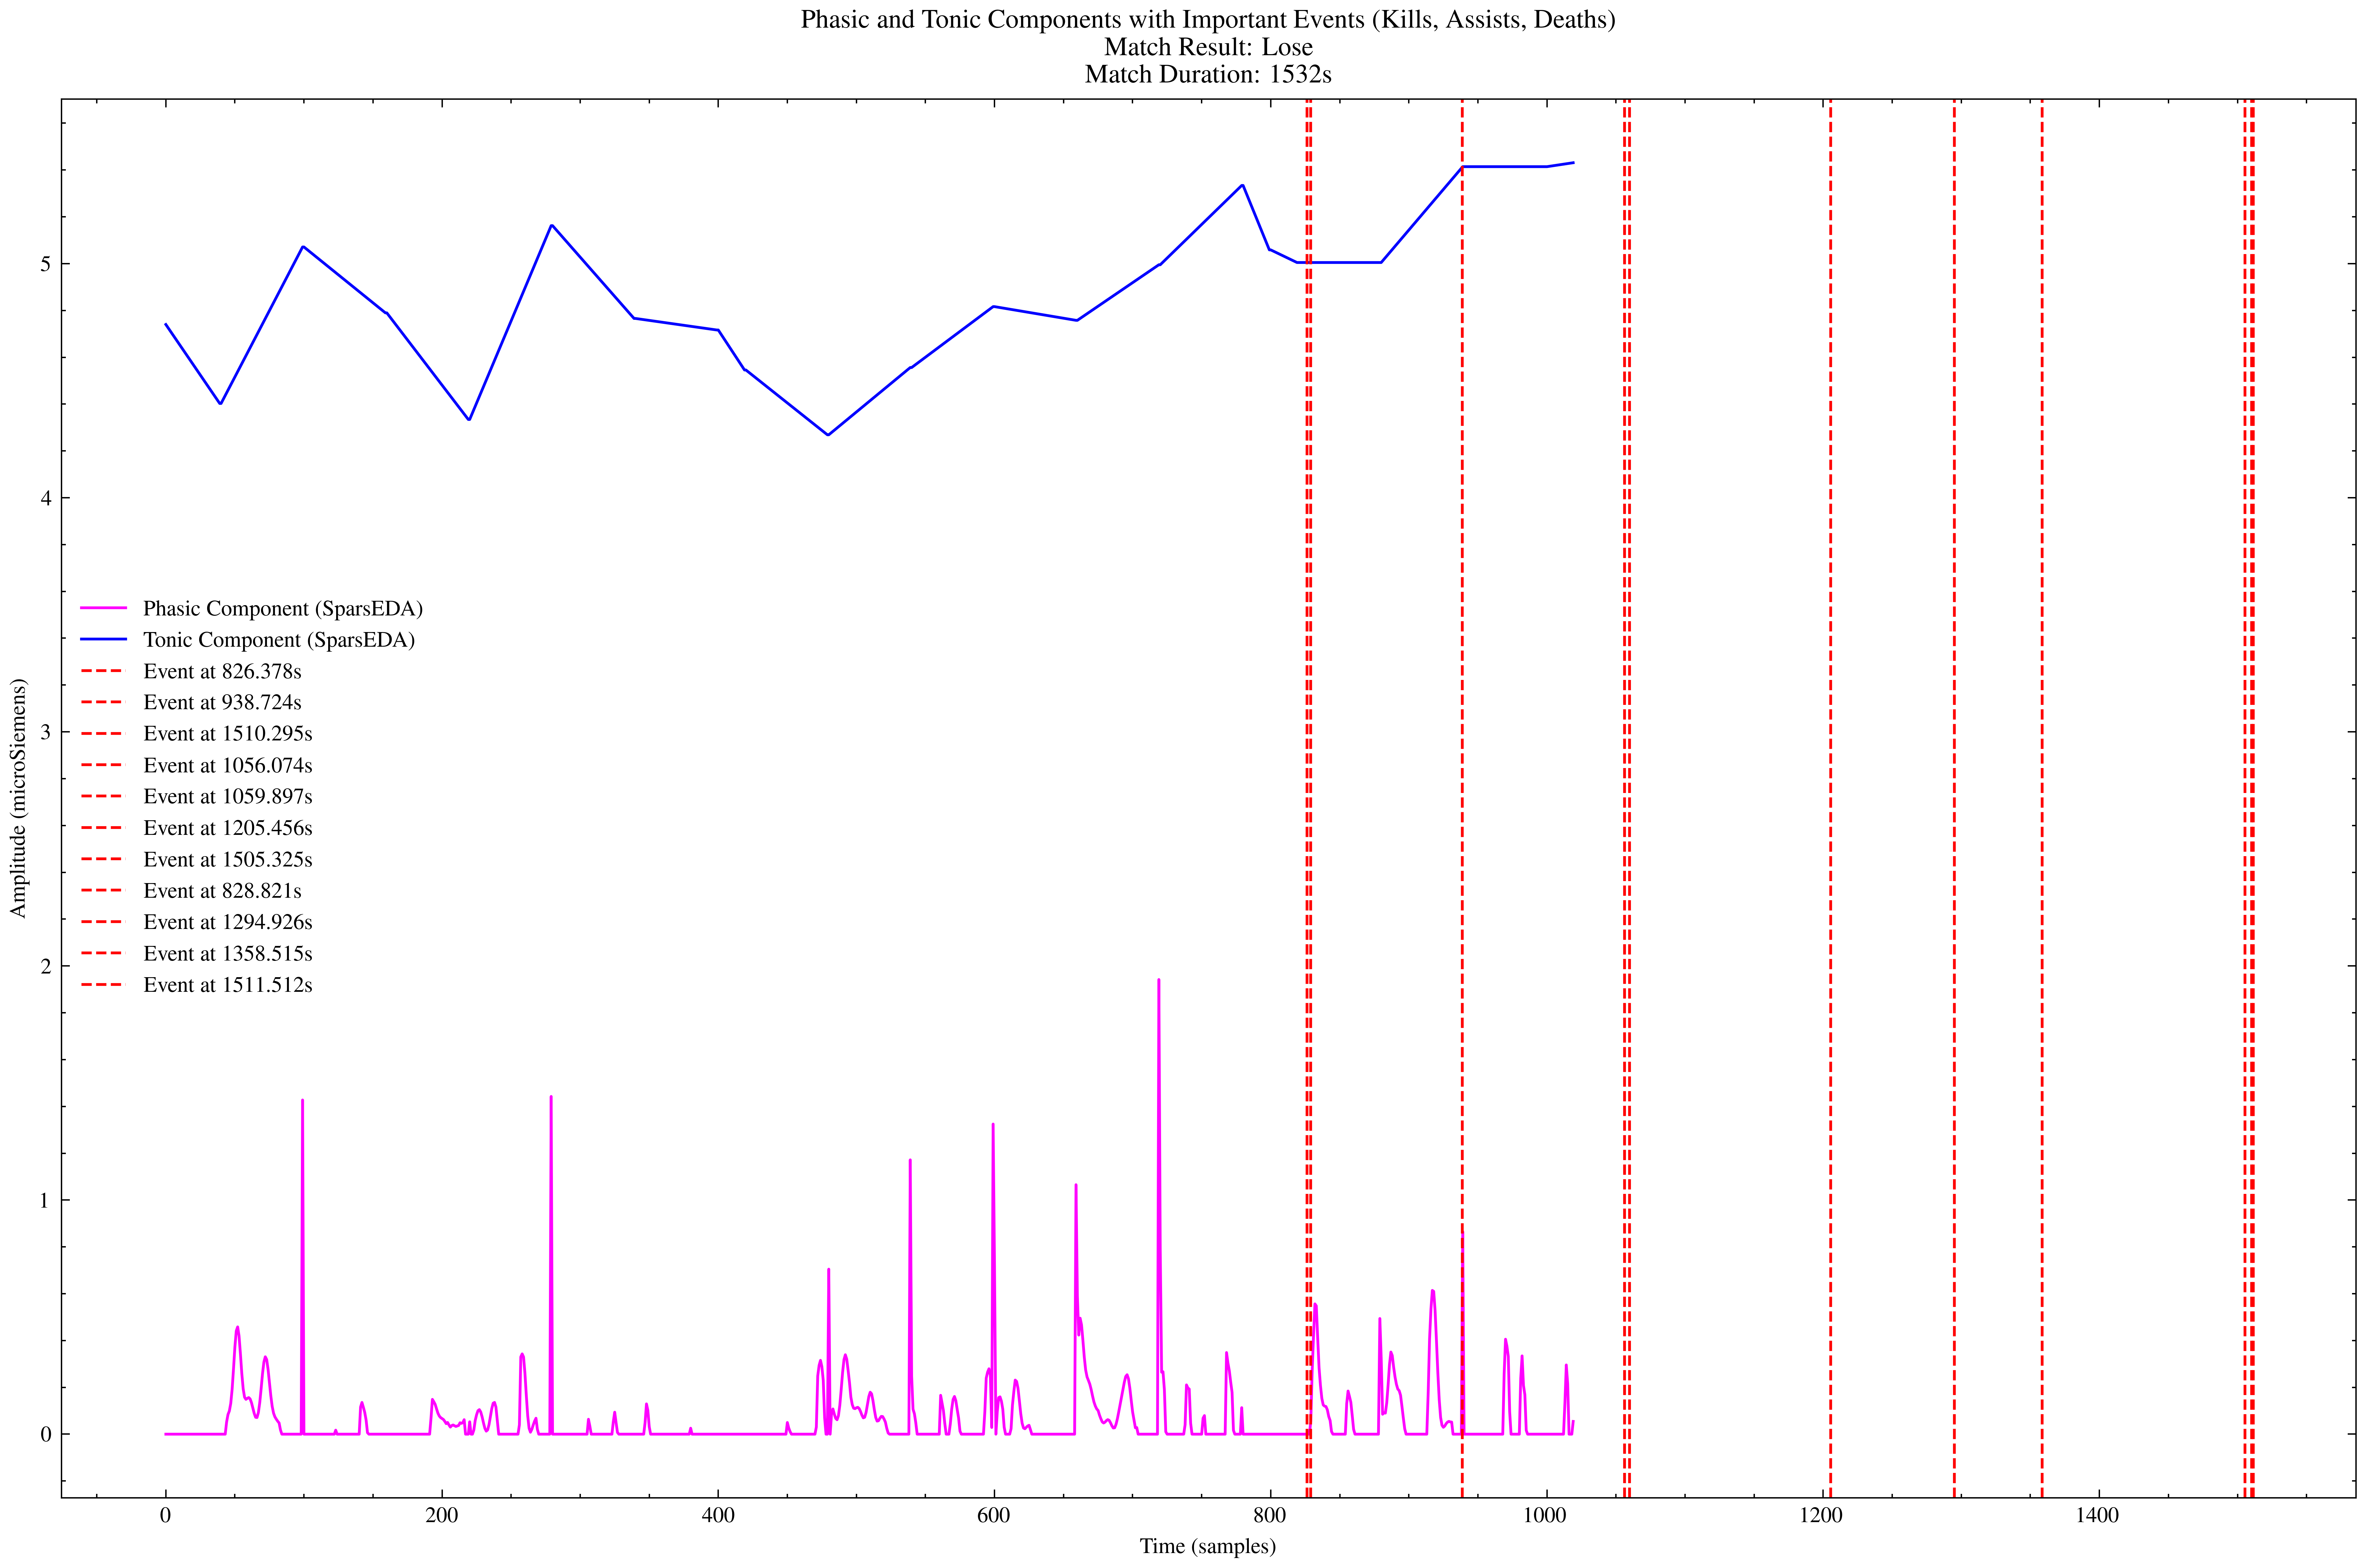

In [73]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxEDA import cvxEDA
from sparsEDA import sparsEDA
import random
import scienceplots
from scipy.interpolate import interp1d

# Use IEEE scienceplot style for academic styling
plt.style.use(['science', 'ieee'])

# Load replay data
def load_replay_data(replay_file_path):
    with open(replay_file_path, 'r') as file:
        replay_data = json.load(file)
    return replay_data

# Load match metadata
def load_match_metadata(meta_info_path):
    with open(meta_info_path, 'r') as file:
        meta_info = json.load(file)
    return meta_info

# Determine if the player won or lost
def determine_player_result(player_id, replay_data):
    team_data = replay_data.get("teams", {})
    player_team_id = 100 if player_id in team_data["participants"]["players"] else 200
    match_result = team_data["participants"]["win"] if player_team_id == 100 else team_data["opponents"]["win"]
    return "Win" if match_result == "Win" else "Lose"

# Plot Phasic and Tonic Components with Important Events
def plot_phasic_tonic_with_events(phasic_signal, tonic_signal, event_times, sampling_rate, player_folder, match_result, match_meta):
    plt.figure(figsize=(12, 8))
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    for event_time in event_times:
        plt.axvline(x=event_time * sampling_rate, color='red', linestyle='--', label=f'Event at {event_time}s')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Important Events (Kills, Assists, Deaths)\nMatch Result: {match_result}\nMatch Duration: {match_meta["match_duration"]}s')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phasic_tonic_events_{player_folder}.png', dpi=300)
    plt.show()

# Plot Timeline Overview of Replay Events
def plot_timeline_overview(replay_data, player_data, phasic_signal, tonic_signal, sampling_rate, player_folder, match_result, match_meta):
    plt.figure(figsize=(20, 30))

    # Plot phasic and tonic signals
    plt.subplot(6, 1, 1)
    plt.plot(phasic_signal, label='Phasic Component (SparsEDA)', color='magenta', linestyle='-')
    plt.plot(tonic_signal, label='Tonic Component (SparsEDA)', color='blue', linestyle='-')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (microSiemens)')
    plt.title(f'Phasic and Tonic Components with Timeline Overview\nMatch Result: {match_result}\nMatch Duration: {match_meta["match_duration"]}s')
    plt.legend()

    # Extract data from replay
    original_timestamps = [entry['timestamp'] for entry in player_data['timelineStats']]
    original_total_gold = [entry['totalGold'] for entry in player_data['timelineStats']]
    total_damage_dealt = [entry.get('totalDamageDealt', 0) for entry in player_data['timelineStats']]
    total_damage_taken = [entry.get('totalDamageTaken', 0) for entry in player_data['timelineStats']]
    xp = [entry.get('xp', 0) for entry in player_data['timelineStats']]
    current_gold = [entry.get('currentGold', 0) for entry in player_data['timelineStats']]
    level = [entry.get('level', 0) for entry in player_data['timelineStats']]

    # Resample timestamps and interpolate values to match GSR data length
    gsr_length = len(phasic_signal)
    max_timestamp = original_timestamps[-1]
    resampled_timestamps = np.linspace(0, max_timestamp, gsr_length)

    # Interpolate all relevant parameters to match the new timestamps
    interpolator_gold = interp1d(original_timestamps, original_total_gold, kind='linear', fill_value='extrapolate')
    interpolator_damage = interp1d(original_timestamps, total_damage_dealt, kind='linear', fill_value='extrapolate')
    interpolator_taken = interp1d(original_timestamps, total_damage_taken, kind='linear', fill_value='extrapolate')
    interpolator_xp = interp1d(original_timestamps, xp, kind='linear', fill_value='extrapolate')
    interpolator_current_gold = interp1d(original_timestamps, current_gold, kind='linear', fill_value='extrapolate')
    interpolator_level = interp1d(original_timestamps, level, kind='linear', fill_value='extrapolate')

    resampled_total_gold = interpolator_gold(resampled_timestamps)
    resampled_total_damage = interpolator_damage(resampled_timestamps)
    resampled_total_taken = interpolator_taken(resampled_timestamps)
    resampled_xp = interpolator_xp(resampled_timestamps)
    resampled_current_gold = interpolator_current_gold(resampled_timestamps)
    resampled_level = interpolator_level(resampled_timestamps)

    # Plot total gold earned, current gold, kills, assists, and deaths
    plt.subplot(6, 1, 2)
    plt.plot(resampled_timestamps, resampled_total_gold, label='Total Gold Earned', color='gold', linestyle='-')
    plt.plot(resampled_timestamps, resampled_current_gold, label='Current Gold', color='orange', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gold')
    plt.title('Total Gold Earned and Current Gold Over Time')
    plt.legend()

    # Plot kills, assists, and deaths
    kills = player_data['killTimes']
    assists = player_data['assistTimes']
    deaths = player_data['deathTimes']

    for kill_time in kills:
        plt.axvline(x=kill_time, color='green', linestyle='-', label='Kill')
    for assist_time in assists:
        plt.axvline(x=assist_time, color='blue', linestyle='--', label='Assist')
    for death_time in deaths:
        plt.axvline(x=death_time, color='black', linestyle='-.', label='Death')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Events')
    plt.title('Kills, Assists, and Deaths Over Time')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'timeline_overview_player_{player_folder}.png', dpi=300)
    plt.show()

# Function to process player data and analyze replay events
def process_player_data_and_analyze_events(player_path, replay_file_path, meta_info_path, match_folder, player_folder):
    # Load replay data
    replay_data = load_replay_data(replay_file_path)
    player_data = replay_data.get('player_0', {})

    # Load match metadata
    match_meta = load_match_metadata(meta_info_path)

    # Get important event times
    kill_times = player_data.get('killTimes', [])
    assist_times = player_data.get('assistTimes', [])
    death_times = player_data.get('deathTimes', [])
    event_times = kill_times + assist_times + death_times

    # Load GSR data
    gsr_file = os.path.join(player_path, "gsr.csv")
    if not os.path.exists(gsr_file):
        print(f"Missing GSR data for player in {player_path}")
        return

    df_gsr = pd.read_csv(gsr_file)
    gsr_data = df_gsr['gsr'].values

    # Convert GSR from resistance (Ohms) to conductance (microSiemens)
    gsr_data = (1 / gsr_data) * 1e5

    # Preprocess GSR with wavelet denoising
    gsr_data = wavelet_denoise_gsr_signal(gsr_data)

    # Decompose GSR using SparsEDA
    sampling_rate = 1  # Assume the GSR data is sampled at 1 Hz
    epsilon = 0.001
    Kmax = 50000
    dmin = 1
    rho = 0.002
    driver_sparseda, SCL_sparseda, _ = sparsEDA(gsr_data, sampling_rate, epsilon, Kmax, dmin, rho)

    # Determine match result
    player_id = 0  # Assuming player_0
    match_result = determine_player_result(player_id, replay_data)

    # Plot phasic and tonic components with event markers
    plot_phasic_tonic_with_events(driver_sparseda, SCL_sparseda, event_times, sampling_rate, player_folder, match_result, match_meta)

    # Plot timeline overview with player activity
    plot_timeline_overview(replay_data, player_data, driver_sparseda, SCL_sparseda, sampling_rate, player_folder, match_result, match_meta)

# Helper function to get random player path
def get_random_player_path(base_dir):
    match_dir = os.path.join(base_dir, "matches")
    match_folders = [f for f in os.listdir(match_dir) if os.path.isdir(os.path.join(match_dir, f))]
    if not match_folders:
        raise FileNotFoundError("No match folders found in the directory")
    random_match_folder = random.choice(match_folders)
    player_dir = os.path.join(match_dir, random_match_folder)
    player_folders = [f for f in os.listdir(player_dir) if os.path.isdir(os.path.join(player_dir, f)) and "player_" in f]
    if not player_folders:
        raise FileNotFoundError(f"No player folders found in match folder: {random_match_folder}")
    random_player_folder = random.choice(player_folders)
    player_path = os.path.join(player_dir, random_player_folder)
    return player_path, random_match_folder, random_player_folder

# Main script execution
if __name__ == "__main__":
    base_dir = r"D:\eSports_Sensors_Dataset-master"
    match_folder = "match_1"
    replay_file_path = os.path.join(base_dir, f"matches/{match_folder}/replay.json")
    meta_info_path = os.path.join(base_dir, f"matches/{match_folder}/meta_info.json")

    # Get random player path and folder names
    player_path, match_folder, player_folder = get_random_player_path(base_dir)
    print(f"Randomly selected player path: {player_path}")
    print(f"Random match folder: {match_folder}")
    print(f"Random player folder: {player_folder}")

    # Call the function to process player data and analyze events
    process_player_data_and_analyze_events(player_path, replay_file_path, meta_info_path, match_folder, player_folder)
